In [9]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator

import torchmetrics
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

from multiprocessing import cpu_count

In [48]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 16, 10

tqdm.pandas()

In [11]:
pl.seed_everything(42)

Seed set to 42


42

In [12]:
X_train = pd.read_csv('./career-con-2019/X_train.csv')
y_train = pd.read_csv('./career-con-2019/y_train.csv')

In [13]:
y_train.head()

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles


In [14]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(y_train.surface)
encoded_labels[:5]

array([2, 1, 1, 1, 6])

In [15]:
label_encoder.classes_

array(['carpet', 'concrete', 'fine_concrete', 'hard_tiles',
       'hard_tiles_large_space', 'soft_pvc', 'soft_tiles', 'tiled',
       'wood'], dtype=object)

In [16]:
y_train['label'] = encoded_labels
y_train.head()

,series_id,group_id,surface,label
0,0,13,fine_concrete,2
1,1,31,concrete,1
2,2,20,concrete,1
3,3,31,concrete,1
4,4,22,soft_tiles,6


In [17]:
FEATURE_COLUMNS = X_train.columns.tolist()[3:]
FEATURE_COLUMNS

['orientation_X',
 'orientation_Y',
 'orientation_Z',
 'orientation_W',
 'angular_velocity_X',
 'angular_velocity_Y',
 'angular_velocity_Z',
 'linear_acceleration_X',
 'linear_acceleration_Y',
 'linear_acceleration_Z']

In [18]:
LABEL_COLUMNS = y_train.columns.tolist()

In [19]:
# checking to see if each of the examples has a label in the y_train

(X_train.series_id.value_counts() == 128).sum() == len(y_train)

True

In [20]:
sequences = []

for series_id, group in X_train.groupby('series_id'):
  sequence_features = group[FEATURE_COLUMNS]

  label = y_train[y_train.series_id == series_id].iloc[0].label

  sequences.append((sequence_features, label))

In [21]:
train_sequences, test_sequences = train_test_split(sequences,test_size=0.2)

In [22]:
len(train_sequences), len(test_sequences)

(3048, 762)

In [247]:
class SurfaceDataset(Dataset):

  def __init__(self,sequences):
    self.sequences = sequences

  def __len__(self):
    return len(self.sequences)

  def __getitem__(self,idx):
    sequence, label = self.sequences[idx]
    sequence_tensor = torch.Tensor(sequence.to_numpy())
    # Ensure label is a tensor with the same dimensions as sequence
    label_tensor = torch.Tensor([label]).long()
    return dict(
        sequence = sequence_tensor,
        labels = label_tensor
    )

In [248]:
class SurfaceDataModule(pl.LightningDataModule):

    def __init__(self, train_sequences, test_sequences, batch_size=8):
        super().__init__()
        self.batch_size = batch_size
        self.train_sequences = train_sequences
        self.test_sequences = test_sequences

    def setup(self, stage=None):
        self.train_dataset = SurfaceDataset(self.train_sequences)
        self.test_dataset = SurfaceDataset(self.test_sequences)

    def train_dataloader(self):
        return DataLoader(
          self.train_dataset,
          batch_size=self.batch_size,
          shuffle=True,
          num_workers=cpu_count()
        )

    def val_dataloader(self):
        return DataLoader(
          self.test_dataset,
          batch_size=self.batch_size,
          shuffle=False,
          num_workers=cpu_count()
        )

    def test_dataloader(self):
        return DataLoader(
          self.test_dataset,
          batch_size=self.batch_size,
          shuffle=False,
          num_workers=cpu_count()
        )

In [258]:
N_EPOCHS = 300
BATCH_SIZE = 64

data_module = SurfaceDataModule(
  train_sequences,
  test_sequences,
  batch_size=BATCH_SIZE
)

In [266]:
class SequenceModel(nn.Module):
  def __init__(self,n_features, n_classes, n_hidden=512, n_layers=3):
    super().__init__()
    
    self.lstm = nn.LSTM(
        input_size=n_features,
        hidden_size=n_hidden,
        num_layers=n_layers,
        batch_first=True,
        dropout=0.9
    )

    self.classifier = nn.Linear(n_hidden,n_classes)

  def forward(self,x):
    self.lstm.flatten_parameters()
    _,(hidden,_) = self.lstm(x)

    out = hidden[-1]
    return self.classifier(out)

In [267]:
class SurfacePredictor(pl.LightningModule):

  def __init__(self,n_features:int, n_classes: int):
    super().__init__()
    self.model = SequenceModel(n_features, n_classes)
    self.criterion = nn.CrossEntropyLoss()
    self.n_classes = n_classes

  def forward(self, x, labels=None):
    output = self.model(x)
    loss = 0
    if labels is not None:
        loss = self.criterion(output, labels)
    return loss, output

  def training_step(self, batch, batch_idx):
    sequences = batch["sequence"]
    labels = batch["labels"].squeeze()
    loss, outputs = self(sequences, labels)
    predictions = torch.argmax(outputs,dim=1)
    step_accuracy = torchmetrics.functional.accuracy(predictions, labels, task="multiclass", num_classes=self.n_classes)

    self.log("train_loss", loss, prog_bar=True, logger=True)
    self.log("train_accuracy", step_accuracy, prog_bar=True, logger=True)
    return {"loss": loss, "accuracy": step_accuracy}

  def validation_step(self, batch, batch_idx):
    sequences = batch["sequence"]
    labels = batch["labels"].squeeze()
    loss, outputs = self(sequences, labels)
    predictions = torch.argmax(outputs,dim=1)
    step_accuracy = torchmetrics.functional.accuracy(predictions, labels, task="multiclass", num_classes=self.n_classes)

    self.log("val_loss", loss, prog_bar=True, logger=True)
    self.log("val_accuracy", step_accuracy, prog_bar=True, logger=True)
    return {"loss": loss, "accuracy": step_accuracy}

  def test_step(self, batch, batch_idx):
    
    sequences = batch["sequence"]
    labels = batch["labels"].squeeze()
    loss, outputs = self(sequences, labels)
    predictions = torch.argmax(outputs,dim=1)
    step_accuracy = torchmetrics.functional.accuracy(predictions, labels, task="multiclass", num_classes=self.n_classes)

    self.log("test_loss", loss, prog_bar=True, logger=True)
    self.log("test_accuracy", step_accuracy, prog_bar=True, logger=True)
    return {"loss": loss, "accuracy": step_accuracy}

  
  def configure_optimizers(self):
    return optim.Adam(self.parameters(), lr=0.0001)

In [268]:
model = SurfacePredictor(n_features=len(FEATURE_COLUMNS),n_classes=len(label_encoder.classes_))

In [269]:
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [270]:
import torch
print(torch.cuda.is_available())


True


In [271]:
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min"
)

#early_stopping_callback = EarlyStopping(monitor='val_loss', patience=30)

trainer = pl.Trainer(
    callbacks=[checkpoint_callback], # [early_stopping_callback, checkpoint_callback]
    max_epochs=N_EPOCHS,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [272]:
trainer.fit(model, data_module)

/home/till/anaconda3/envs/advml/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /home/till/Desktop/ds4w-user-identification/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | SequenceModel    | 5.3 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
5.3 M     Trainable params
0         Non-trainable params
5.3 M     Total params
21.121    Total estimated model params size (MB)


/home/till/anaconda3/envs/advml/lib/python3.9/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (48) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|████████████████████████████████| 48/48 [00:00<00:00, 52.44it/s, v_num=25, train_loss=2.130, train_accuracy=0.175]
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 146.51it/s]
Epoch 0: 100%|█| 48/48 [00:01<00:00, 30.47it/s, v_num=25, train_loss=2.130, train_accuracy=0.175, val_loss=2.030, val_accuracy=0

Epoch 0, global step 48: 'val_loss' reached 2.03033 (best 2.03033), saving model to '/home/till/Desktop/ds4w-user-identification/checkpoints/best-checkpoint-v24.ckpt' as top 1


Epoch 1: 100%|█| 48/48 [00:01<00:00, 32.04it/s, v_num=25, train_loss=1.980, train_accuracy=0.250, val_loss=2.030, val_accuracy=0
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 139.88it/s]
Epoch 1: 100%|█| 48/48 [00:02<00:00, 21.97it/s, v_num=25, train_loss=1.980, train_accuracy=0.250, val_loss=2.030, val_accuracy=0

Epoch 1, global step 96: 'val_loss' reached 2.02671 (best 2.02671), saving model to '/home/till/Desktop/ds4w-user-identification/checkpoints/best-checkpoint-v24.ckpt' as top 1


Epoch 2: 100%|█| 48/48 [00:01<00:00, 33.59it/s, v_num=25, train_loss=2.030, train_accuracy=0.175, val_loss=2.030, val_accuracy=0
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.68it/s]
Epoch 2: 100%|█| 48/48 [00:02<00:00, 23.30it/s, v_num=25, train_loss=2.030, train_accuracy=0.175, val_loss=2.030, val_accuracy=0

Epoch 2, global step 144: 'val_loss' was not in top 1


Epoch 3: 100%|█| 48/48 [00:01<00:00, 32.42it/s, v_num=25, train_loss=2.060, train_accuracy=0.200, val_loss=2.030, val_accuracy=0
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 131.41it/s]
Epoch 3: 100%|█| 48/48 [00:02<00:00, 22.15it/s, v_num=25, train_loss=2.060, train_accuracy=0.200, val_loss=2.030, val_accuracy=0

Epoch 3, global step 192: 'val_loss' was not in top 1


Epoch 4: 100%|█| 48/48 [00:01<00:00, 32.68it/s, v_num=25, train_loss=1.890, train_accuracy=0.175, val_loss=2.030, val_accuracy=0
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.36it/s]
Epoch 4: 100%|█| 48/48 [00:02<00:00, 22.74it/s, v_num=25, train_loss=1.890, train_accuracy=0.175, val_loss=2.030, val_accuracy=0

Epoch 4, global step 240: 'val_loss' was not in top 1


Epoch 5: 100%|█| 48/48 [00:01<00:00, 32.71it/s, v_num=25, train_loss=1.930, train_accuracy=0.325, val_loss=2.030, val_accuracy=0
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.12it/s]
Epoch 5: 100%|█| 48/48 [00:02<00:00, 22.77it/s, v_num=25, train_loss=1.930, train_accuracy=0.325, val_loss=2.020, val_accuracy=0

Epoch 5, global step 288: 'val_loss' reached 2.02139 (best 2.02139), saving model to '/home/till/Desktop/ds4w-user-identification/checkpoints/best-checkpoint-v24.ckpt' as top 1


Epoch 6: 100%|█| 48/48 [00:01<00:00, 32.31it/s, v_num=25, train_loss=1.890, train_accuracy=0.300, val_loss=2.020, val_accuracy=0
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 153.09it/s]
Epoch 6: 100%|█| 48/48 [00:02<00:00, 22.12it/s, v_num=25, train_loss=1.890, train_accuracy=0.300, val_loss=1.970, val_accuracy=0

Epoch 6, global step 336: 'val_loss' reached 1.97082 (best 1.97082), saving model to '/home/till/Desktop/ds4w-user-identification/checkpoints/best-checkpoint-v24.ckpt' as top 1


Epoch 7: 100%|█| 48/48 [00:01<00:00, 31.76it/s, v_num=25, train_loss=1.980, train_accuracy=0.125, val_loss=1.970, val_accuracy=0
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 146.75it/s]
Epoch 7: 100%|█| 48/48 [00:02<00:00, 22.39it/s, v_num=25, train_loss=1.980, train_accuracy=0.125, val_loss=1.960, val_accuracy=0

Epoch 7, global step 384: 'val_loss' reached 1.95883 (best 1.95883), saving model to '/home/till/Desktop/ds4w-user-identification/checkpoints/best-checkpoint-v24.ckpt' as top 1


Epoch 8: 100%|█| 48/48 [00:01<00:00, 32.65it/s, v_num=25, train_loss=1.930, train_accuracy=0.275, val_loss=1.960, val_accuracy=0
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.54it/s]
Epoch 8: 100%|█| 48/48 [00:02<00:00, 22.48it/s, v_num=25, train_loss=1.930, train_accuracy=0.275, val_loss=2.010, val_accuracy=0

Epoch 8, global step 432: 'val_loss' was not in top 1


Epoch 9: 100%|█| 48/48 [00:01<00:00, 32.85it/s, v_num=25, train_loss=1.970, train_accuracy=0.300, val_loss=2.010, val_accuracy=0
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.99it/s]
Epoch 9: 100%|█| 48/48 [00:02<00:00, 22.55it/s, v_num=25, train_loss=1.970, train_accuracy=0.300, val_loss=1.930, val_accuracy=0

Epoch 9, global step 480: 'val_loss' reached 1.92878 (best 1.92878), saving model to '/home/till/Desktop/ds4w-user-identification/checkpoints/best-checkpoint-v24.ckpt' as top 1


Epoch 10: 100%|█| 48/48 [00:01<00:00, 32.46it/s, v_num=25, train_loss=1.800, train_accuracy=0.375, val_loss=1.930, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 144.71it/s]
Epoch 10: 100%|█| 48/48 [00:02<00:00, 22.34it/s, v_num=25, train_loss=1.800, train_accuracy=0.375, val_loss=1.870, val_accuracy=

Epoch 10, global step 528: 'val_loss' reached 1.86505 (best 1.86505), saving model to '/home/till/Desktop/ds4w-user-identification/checkpoints/best-checkpoint-v24.ckpt' as top 1


Epoch 11: 100%|█| 48/48 [00:01<00:00, 31.94it/s, v_num=25, train_loss=1.830, train_accuracy=0.275, val_loss=1.870, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 132.12it/s]
Epoch 11: 100%|█| 48/48 [00:02<00:00, 21.91it/s, v_num=25, train_loss=1.830, train_accuracy=0.275, val_loss=1.940, val_accuracy=

Epoch 11, global step 576: 'val_loss' was not in top 1


Epoch 12: 100%|█| 48/48 [00:01<00:00, 32.48it/s, v_num=25, train_loss=1.780, train_accuracy=0.325, val_loss=1.940, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.46it/s]
Epoch 12: 100%|█| 48/48 [00:02<00:00, 22.61it/s, v_num=25, train_loss=1.780, train_accuracy=0.325, val_loss=1.800, val_accuracy=

Epoch 12, global step 624: 'val_loss' reached 1.80180 (best 1.80180), saving model to '/home/till/Desktop/ds4w-user-identification/checkpoints/best-checkpoint-v24.ckpt' as top 1


Epoch 13: 100%|█| 48/48 [00:01<00:00, 31.52it/s, v_num=25, train_loss=1.690, train_accuracy=0.375, val_loss=1.800, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.29it/s]
Epoch 13: 100%|█| 48/48 [00:02<00:00, 22.27it/s, v_num=25, train_loss=1.690, train_accuracy=0.375, val_loss=1.800, val_accuracy=

Epoch 13, global step 672: 'val_loss' was not in top 1


Epoch 14: 100%|█| 48/48 [00:01<00:00, 32.52it/s, v_num=25, train_loss=1.920, train_accuracy=0.225, val_loss=1.800, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 136.41it/s]
Epoch 14: 100%|█| 48/48 [00:02<00:00, 22.72it/s, v_num=25, train_loss=1.920, train_accuracy=0.225, val_loss=1.740, val_accuracy=

Epoch 14, global step 720: 'val_loss' reached 1.74048 (best 1.74048), saving model to '/home/till/Desktop/ds4w-user-identification/checkpoints/best-checkpoint-v24.ckpt' as top 1


Epoch 15: 100%|█| 48/48 [00:01<00:00, 32.17it/s, v_num=25, train_loss=1.570, train_accuracy=0.325, val_loss=1.740, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.47it/s]
Epoch 15: 100%|█| 48/48 [00:02<00:00, 22.76it/s, v_num=25, train_loss=1.570, train_accuracy=0.325, val_loss=1.710, val_accuracy=

Epoch 15, global step 768: 'val_loss' reached 1.70989 (best 1.70989), saving model to '/home/till/Desktop/ds4w-user-identification/checkpoints/best-checkpoint-v24.ckpt' as top 1


Epoch 16: 100%|█| 48/48 [00:01<00:00, 32.33it/s, v_num=25, train_loss=1.550, train_accuracy=0.400, val_loss=1.710, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.70it/s]
Epoch 16: 100%|█| 48/48 [00:02<00:00, 22.56it/s, v_num=25, train_loss=1.550, train_accuracy=0.400, val_loss=1.730, val_accuracy=

Epoch 16, global step 816: 'val_loss' was not in top 1


Epoch 17: 100%|█| 48/48 [00:01<00:00, 33.48it/s, v_num=25, train_loss=1.760, train_accuracy=0.275, val_loss=1.730, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 137.35it/s]
Epoch 17: 100%|█| 48/48 [00:02<00:00, 22.82it/s, v_num=25, train_loss=1.760, train_accuracy=0.275, val_loss=2.110, val_accuracy=

Epoch 17, global step 864: 'val_loss' was not in top 1


Epoch 18: 100%|█| 48/48 [00:01<00:00, 33.11it/s, v_num=25, train_loss=1.490, train_accuracy=0.375, val_loss=2.110, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 137.22it/s]
Epoch 18: 100%|█| 48/48 [00:02<00:00, 23.11it/s, v_num=25, train_loss=1.490, train_accuracy=0.375, val_loss=1.730, val_accuracy=

Epoch 18, global step 912: 'val_loss' was not in top 1


Epoch 19: 100%|█| 48/48 [00:01<00:00, 33.51it/s, v_num=25, train_loss=1.470, train_accuracy=0.450, val_loss=1.730, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.02it/s]
Epoch 19: 100%|█| 48/48 [00:02<00:00, 23.07it/s, v_num=25, train_loss=1.470, train_accuracy=0.450, val_loss=1.670, val_accuracy=

Epoch 19, global step 960: 'val_loss' reached 1.67395 (best 1.67395), saving model to '/home/till/Desktop/ds4w-user-identification/checkpoints/best-checkpoint-v24.ckpt' as top 1


Epoch 20: 100%|█| 48/48 [00:01<00:00, 32.22it/s, v_num=25, train_loss=1.580, train_accuracy=0.400, val_loss=1.670, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 139.33it/s]
Epoch 20: 100%|█| 48/48 [00:02<00:00, 22.18it/s, v_num=25, train_loss=1.580, train_accuracy=0.400, val_loss=1.700, val_accuracy=

Epoch 20, global step 1008: 'val_loss' was not in top 1


Epoch 21: 100%|█| 48/48 [00:01<00:00, 32.25it/s, v_num=25, train_loss=1.460, train_accuracy=0.500, val_loss=1.700, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 138.59it/s]
Epoch 21: 100%|█| 48/48 [00:02<00:00, 22.63it/s, v_num=25, train_loss=1.460, train_accuracy=0.500, val_loss=1.630, val_accuracy=

Epoch 21, global step 1056: 'val_loss' reached 1.63095 (best 1.63095), saving model to '/home/till/Desktop/ds4w-user-identification/checkpoints/best-checkpoint-v24.ckpt' as top 1


Epoch 22: 100%|█| 48/48 [00:01<00:00, 32.54it/s, v_num=25, train_loss=1.630, train_accuracy=0.450, val_loss=1.630, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 147.43it/s]
Epoch 22: 100%|█| 48/48 [00:02<00:00, 22.37it/s, v_num=25, train_loss=1.630, train_accuracy=0.450, val_loss=1.670, val_accuracy=

Epoch 22, global step 1104: 'val_loss' was not in top 1


Epoch 23: 100%|█| 48/48 [00:01<00:00, 32.70it/s, v_num=25, train_loss=1.620, train_accuracy=0.375, val_loss=1.670, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.98it/s]
Epoch 23: 100%|█| 48/48 [00:02<00:00, 22.72it/s, v_num=25, train_loss=1.620, train_accuracy=0.375, val_loss=1.650, val_accuracy=

Epoch 23, global step 1152: 'val_loss' was not in top 1


Epoch 24: 100%|█| 48/48 [00:01<00:00, 32.79it/s, v_num=25, train_loss=1.540, train_accuracy=0.300, val_loss=1.650, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 140.74it/s]
Epoch 24: 100%|█| 48/48 [00:02<00:00, 22.79it/s, v_num=25, train_loss=1.540, train_accuracy=0.300, val_loss=1.560, val_accuracy=

Epoch 24, global step 1200: 'val_loss' reached 1.56299 (best 1.56299), saving model to '/home/till/Desktop/ds4w-user-identification/checkpoints/best-checkpoint-v24.ckpt' as top 1


Epoch 25: 100%|█| 48/48 [00:01<00:00, 33.00it/s, v_num=25, train_loss=1.690, train_accuracy=0.400, val_loss=1.560, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 143.26it/s]
Epoch 25: 100%|█| 48/48 [00:02<00:00, 23.15it/s, v_num=25, train_loss=1.690, train_accuracy=0.400, val_loss=1.840, val_accuracy=

Epoch 25, global step 1248: 'val_loss' was not in top 1


Epoch 26: 100%|█| 48/48 [00:01<00:00, 32.15it/s, v_num=25, train_loss=1.480, train_accuracy=0.550, val_loss=1.840, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 140.13it/s]
Epoch 26: 100%|█| 48/48 [00:02<00:00, 22.56it/s, v_num=25, train_loss=1.480, train_accuracy=0.550, val_loss=1.560, val_accuracy=

Epoch 26, global step 1296: 'val_loss' was not in top 1


Epoch 27: 100%|█| 48/48 [00:01<00:00, 31.45it/s, v_num=25, train_loss=1.570, train_accuracy=0.425, val_loss=1.560, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 139.83it/s]
Epoch 27: 100%|█| 48/48 [00:02<00:00, 22.24it/s, v_num=25, train_loss=1.570, train_accuracy=0.425, val_loss=1.490, val_accuracy=

Epoch 27, global step 1344: 'val_loss' reached 1.49302 (best 1.49302), saving model to '/home/till/Desktop/ds4w-user-identification/checkpoints/best-checkpoint-v24.ckpt' as top 1


Epoch 28: 100%|█| 48/48 [00:01<00:00, 32.69it/s, v_num=25, train_loss=1.530, train_accuracy=0.375, val_loss=1.490, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.90it/s]
Epoch 28: 100%|█| 48/48 [00:02<00:00, 22.66it/s, v_num=25, train_loss=1.530, train_accuracy=0.375, val_loss=1.510, val_accuracy=

Epoch 28, global step 1392: 'val_loss' was not in top 1


Epoch 29: 100%|█| 48/48 [00:01<00:00, 32.89it/s, v_num=25, train_loss=1.370, train_accuracy=0.500, val_loss=1.510, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 143.30it/s]
Epoch 29: 100%|█| 48/48 [00:02<00:00, 22.88it/s, v_num=25, train_loss=1.370, train_accuracy=0.500, val_loss=1.490, val_accuracy=

Epoch 29, global step 1440: 'val_loss' was not in top 1


Epoch 30: 100%|█| 48/48 [00:01<00:00, 33.23it/s, v_num=25, train_loss=1.360, train_accuracy=0.525, val_loss=1.490, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.10it/s]
Epoch 30: 100%|█| 48/48 [00:02<00:00, 22.79it/s, v_num=25, train_loss=1.360, train_accuracy=0.525, val_loss=1.550, val_accuracy=

Epoch 30, global step 1488: 'val_loss' was not in top 1


Epoch 31: 100%|█| 48/48 [00:01<00:00, 32.67it/s, v_num=25, train_loss=1.460, train_accuracy=0.475, val_loss=1.550, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.42it/s]
Epoch 31: 100%|█| 48/48 [00:02<00:00, 22.75it/s, v_num=25, train_loss=1.460, train_accuracy=0.475, val_loss=1.450, val_accuracy=

Epoch 31, global step 1536: 'val_loss' reached 1.45098 (best 1.45098), saving model to '/home/till/Desktop/ds4w-user-identification/checkpoints/best-checkpoint-v24.ckpt' as top 1


Epoch 32: 100%|█| 48/48 [00:01<00:00, 32.80it/s, v_num=25, train_loss=1.220, train_accuracy=0.550, val_loss=1.450, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 134.98it/s]
Epoch 32: 100%|█| 48/48 [00:02<00:00, 22.63it/s, v_num=25, train_loss=1.220, train_accuracy=0.550, val_loss=1.380, val_accuracy=

Epoch 32, global step 1584: 'val_loss' reached 1.37662 (best 1.37662), saving model to '/home/till/Desktop/ds4w-user-identification/checkpoints/best-checkpoint-v24.ckpt' as top 1


Epoch 33: 100%|█| 48/48 [00:01<00:00, 33.18it/s, v_num=25, train_loss=1.400, train_accuracy=0.525, val_loss=1.380, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.41it/s]
Epoch 33: 100%|█| 48/48 [00:02<00:00, 22.86it/s, v_num=25, train_loss=1.400, train_accuracy=0.525, val_loss=1.390, val_accuracy=

Epoch 33, global step 1632: 'val_loss' was not in top 1


Epoch 34: 100%|█| 48/48 [00:01<00:00, 32.64it/s, v_num=25, train_loss=1.450, train_accuracy=0.400, val_loss=1.390, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 143.27it/s]
Epoch 34: 100%|█| 48/48 [00:02<00:00, 22.60it/s, v_num=25, train_loss=1.450, train_accuracy=0.400, val_loss=1.390, val_accuracy=

Epoch 34, global step 1680: 'val_loss' was not in top 1


Epoch 35: 100%|█| 48/48 [00:01<00:00, 33.40it/s, v_num=25, train_loss=1.190, train_accuracy=0.575, val_loss=1.390, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.87it/s]
Epoch 35: 100%|█| 48/48 [00:02<00:00, 23.28it/s, v_num=25, train_loss=1.190, train_accuracy=0.575, val_loss=1.420, val_accuracy=

Epoch 35, global step 1728: 'val_loss' was not in top 1


Epoch 36: 100%|█| 48/48 [00:01<00:00, 32.86it/s, v_num=25, train_loss=1.210, train_accuracy=0.600, val_loss=1.420, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 140.67it/s]
Epoch 36: 100%|█| 48/48 [00:02<00:00, 22.69it/s, v_num=25, train_loss=1.210, train_accuracy=0.600, val_loss=1.390, val_accuracy=

Epoch 36, global step 1776: 'val_loss' was not in top 1


Epoch 37: 100%|█| 48/48 [00:01<00:00, 32.60it/s, v_num=25, train_loss=1.350, train_accuracy=0.525, val_loss=1.390, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 153.23it/s]
Epoch 37: 100%|█| 48/48 [00:02<00:00, 22.60it/s, v_num=25, train_loss=1.350, train_accuracy=0.525, val_loss=1.350, val_accuracy=

Epoch 37, global step 1824: 'val_loss' reached 1.35436 (best 1.35436), saving model to '/home/till/Desktop/ds4w-user-identification/checkpoints/best-checkpoint-v24.ckpt' as top 1


Epoch 38: 100%|█| 48/48 [00:01<00:00, 32.83it/s, v_num=25, train_loss=1.150, train_accuracy=0.525, val_loss=1.350, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.50it/s]
Epoch 38: 100%|█| 48/48 [00:02<00:00, 22.24it/s, v_num=25, train_loss=1.150, train_accuracy=0.525, val_loss=1.460, val_accuracy=

Epoch 38, global step 1872: 'val_loss' was not in top 1


Epoch 39: 100%|█| 48/48 [00:01<00:00, 32.43it/s, v_num=25, train_loss=1.290, train_accuracy=0.475, val_loss=1.460, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 136.94it/s]
Epoch 39: 100%|█| 48/48 [00:02<00:00, 22.78it/s, v_num=25, train_loss=1.290, train_accuracy=0.475, val_loss=1.320, val_accuracy=

Epoch 39, global step 1920: 'val_loss' reached 1.31526 (best 1.31526), saving model to '/home/till/Desktop/ds4w-user-identification/checkpoints/best-checkpoint-v24.ckpt' as top 1


Epoch 40: 100%|█| 48/48 [00:01<00:00, 33.30it/s, v_num=25, train_loss=1.260, train_accuracy=0.550, val_loss=1.320, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 132.15it/s]
Epoch 40: 100%|█| 48/48 [00:02<00:00, 22.67it/s, v_num=25, train_loss=1.260, train_accuracy=0.550, val_loss=1.330, val_accuracy=

Epoch 40, global step 1968: 'val_loss' was not in top 1


Epoch 41: 100%|█| 48/48 [00:01<00:00, 32.94it/s, v_num=25, train_loss=1.330, train_accuracy=0.500, val_loss=1.330, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.94it/s]
Epoch 41: 100%|█| 48/48 [00:02<00:00, 22.58it/s, v_num=25, train_loss=1.330, train_accuracy=0.500, val_loss=1.380, val_accuracy=

Epoch 41, global step 2016: 'val_loss' was not in top 1


Epoch 42: 100%|█| 48/48 [00:01<00:00, 32.55it/s, v_num=25, train_loss=1.300, train_accuracy=0.475, val_loss=1.380, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 136.31it/s]
Epoch 42: 100%|█| 48/48 [00:02<00:00, 22.89it/s, v_num=25, train_loss=1.300, train_accuracy=0.475, val_loss=1.340, val_accuracy=

Epoch 42, global step 2064: 'val_loss' was not in top 1


Epoch 43: 100%|█| 48/48 [00:01<00:00, 31.96it/s, v_num=25, train_loss=1.280, train_accuracy=0.525, val_loss=1.340, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.32it/s]
Epoch 43: 100%|█| 48/48 [00:02<00:00, 22.31it/s, v_num=25, train_loss=1.280, train_accuracy=0.525, val_loss=1.420, val_accuracy=

Epoch 43, global step 2112: 'val_loss' was not in top 1


Epoch 44: 100%|█| 48/48 [00:01<00:00, 32.45it/s, v_num=25, train_loss=1.430, train_accuracy=0.500, val_loss=1.420, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.05it/s]
Epoch 44: 100%|█| 48/48 [00:02<00:00, 22.68it/s, v_num=25, train_loss=1.430, train_accuracy=0.500, val_loss=1.280, val_accuracy=

Epoch 44, global step 2160: 'val_loss' reached 1.28441 (best 1.28441), saving model to '/home/till/Desktop/ds4w-user-identification/checkpoints/best-checkpoint-v24.ckpt' as top 1


Epoch 45: 100%|█| 48/48 [00:01<00:00, 32.81it/s, v_num=25, train_loss=1.270, train_accuracy=0.525, val_loss=1.280, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 133.75it/s]
Epoch 45: 100%|█| 48/48 [00:02<00:00, 22.80it/s, v_num=25, train_loss=1.270, train_accuracy=0.525, val_loss=1.250, val_accuracy=

Epoch 45, global step 2208: 'val_loss' reached 1.25287 (best 1.25287), saving model to '/home/till/Desktop/ds4w-user-identification/checkpoints/best-checkpoint-v24.ckpt' as top 1


Epoch 46: 100%|█| 48/48 [00:01<00:00, 32.72it/s, v_num=25, train_loss=1.430, train_accuracy=0.500, val_loss=1.250, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.27it/s]
Epoch 46: 100%|█| 48/48 [00:02<00:00, 22.61it/s, v_num=25, train_loss=1.430, train_accuracy=0.500, val_loss=1.240, val_accuracy=

Epoch 46, global step 2256: 'val_loss' reached 1.24132 (best 1.24132), saving model to '/home/till/Desktop/ds4w-user-identification/checkpoints/best-checkpoint-v24.ckpt' as top 1


Epoch 47: 100%|█| 48/48 [00:01<00:00, 33.36it/s, v_num=25, train_loss=1.270, train_accuracy=0.500, val_loss=1.240, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 140.98it/s]
Epoch 47: 100%|█| 48/48 [00:02<00:00, 23.04it/s, v_num=25, train_loss=1.270, train_accuracy=0.500, val_loss=1.270, val_accuracy=

Epoch 47, global step 2304: 'val_loss' was not in top 1


Epoch 48: 100%|█| 48/48 [00:01<00:00, 32.81it/s, v_num=25, train_loss=1.180, train_accuracy=0.575, val_loss=1.270, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 133.56it/s]
Epoch 48: 100%|█| 48/48 [00:02<00:00, 22.65it/s, v_num=25, train_loss=1.180, train_accuracy=0.575, val_loss=1.220, val_accuracy=

Epoch 48, global step 2352: 'val_loss' reached 1.21992 (best 1.21992), saving model to '/home/till/Desktop/ds4w-user-identification/checkpoints/best-checkpoint-v24.ckpt' as top 1


Epoch 49: 100%|█| 48/48 [00:01<00:00, 32.17it/s, v_num=25, train_loss=1.100, train_accuracy=0.650, val_loss=1.220, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.11it/s]
Epoch 49: 100%|█| 48/48 [00:02<00:00, 22.33it/s, v_num=25, train_loss=1.100, train_accuracy=0.650, val_loss=1.170, val_accuracy=

Epoch 49, global step 2400: 'val_loss' reached 1.16901 (best 1.16901), saving model to '/home/till/Desktop/ds4w-user-identification/checkpoints/best-checkpoint-v24.ckpt' as top 1


Epoch 50: 100%|█| 48/48 [00:01<00:00, 32.06it/s, v_num=25, train_loss=1.240, train_accuracy=0.475, val_loss=1.170, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 138.66it/s]
Epoch 50: 100%|█| 48/48 [00:02<00:00, 22.19it/s, v_num=25, train_loss=1.240, train_accuracy=0.475, val_loss=1.130, val_accuracy=

Epoch 50, global step 2448: 'val_loss' reached 1.13340 (best 1.13340), saving model to '/home/till/Desktop/ds4w-user-identification/checkpoints/best-checkpoint-v24.ckpt' as top 1


Epoch 51: 100%|█| 48/48 [00:01<00:00, 32.68it/s, v_num=25, train_loss=1.080, train_accuracy=0.675, val_loss=1.130, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 143.41it/s]
Epoch 51: 100%|█| 48/48 [00:02<00:00, 22.56it/s, v_num=25, train_loss=1.080, train_accuracy=0.675, val_loss=1.090, val_accuracy=

Epoch 51, global step 2496: 'val_loss' reached 1.09160 (best 1.09160), saving model to '/home/till/Desktop/ds4w-user-identification/checkpoints/best-checkpoint-v24.ckpt' as top 1


Epoch 52: 100%|█| 48/48 [00:01<00:00, 32.77it/s, v_num=25, train_loss=1.020, train_accuracy=0.650, val_loss=1.090, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.33it/s]
Epoch 52: 100%|█| 48/48 [00:02<00:00, 22.26it/s, v_num=25, train_loss=1.020, train_accuracy=0.650, val_loss=1.150, val_accuracy=

Epoch 52, global step 2544: 'val_loss' was not in top 1


Epoch 53: 100%|█| 48/48 [00:01<00:00, 33.11it/s, v_num=25, train_loss=1.260, train_accuracy=0.500, val_loss=1.150, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 140.37it/s]
Epoch 53: 100%|█| 48/48 [00:02<00:00, 22.56it/s, v_num=25, train_loss=1.260, train_accuracy=0.500, val_loss=1.310, val_accuracy=

Epoch 53, global step 2592: 'val_loss' was not in top 1


Epoch 54: 100%|█| 48/48 [00:01<00:00, 32.98it/s, v_num=25, train_loss=1.030, train_accuracy=0.600, val_loss=1.310, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 144.49it/s]
Epoch 54: 100%|█| 48/48 [00:02<00:00, 22.57it/s, v_num=25, train_loss=1.030, train_accuracy=0.600, val_loss=1.120, val_accuracy=

Epoch 54, global step 2640: 'val_loss' was not in top 1


Epoch 55: 100%|█| 48/48 [00:01<00:00, 33.08it/s, v_num=25, train_loss=1.280, train_accuracy=0.575, val_loss=1.120, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 136.85it/s]
Epoch 55: 100%|█| 48/48 [00:02<00:00, 22.86it/s, v_num=25, train_loss=1.280, train_accuracy=0.575, val_loss=1.150, val_accuracy=

Epoch 55, global step 2688: 'val_loss' was not in top 1


Epoch 56: 100%|█| 48/48 [00:01<00:00, 32.32it/s, v_num=25, train_loss=1.210, train_accuracy=0.475, val_loss=1.150, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 143.42it/s]
Epoch 56: 100%|█| 48/48 [00:02<00:00, 22.05it/s, v_num=25, train_loss=1.210, train_accuracy=0.475, val_loss=1.160, val_accuracy=

Epoch 56, global step 2736: 'val_loss' was not in top 1


Epoch 57: 100%|█| 48/48 [00:01<00:00, 32.17it/s, v_num=25, train_loss=1.180, train_accuracy=0.625, val_loss=1.160, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 143.21it/s]
Epoch 57: 100%|█| 48/48 [00:02<00:00, 22.20it/s, v_num=25, train_loss=1.180, train_accuracy=0.625, val_loss=1.100, val_accuracy=

Epoch 57, global step 2784: 'val_loss' was not in top 1


Epoch 58: 100%|█| 48/48 [00:01<00:00, 32.79it/s, v_num=25, train_loss=1.370, train_accuracy=0.500, val_loss=1.100, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 138.30it/s]
Epoch 58: 100%|█| 48/48 [00:02<00:00, 22.61it/s, v_num=25, train_loss=1.370, train_accuracy=0.500, val_loss=1.460, val_accuracy=

Epoch 58, global step 2832: 'val_loss' was not in top 1


Epoch 59: 100%|█| 48/48 [00:01<00:00, 32.10it/s, v_num=25, train_loss=1.440, train_accuracy=0.500, val_loss=1.460, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 149.56it/s]
Epoch 59: 100%|█| 48/48 [00:02<00:00, 22.35it/s, v_num=25, train_loss=1.440, train_accuracy=0.500, val_loss=1.380, val_accuracy=

Epoch 59, global step 2880: 'val_loss' was not in top 1


Epoch 60: 100%|█| 48/48 [00:01<00:00, 32.78it/s, v_num=25, train_loss=1.080, train_accuracy=0.625, val_loss=1.380, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 151.44it/s]
Epoch 60: 100%|█| 48/48 [00:02<00:00, 22.76it/s, v_num=25, train_loss=1.080, train_accuracy=0.625, val_loss=1.240, val_accuracy=

Epoch 60, global step 2928: 'val_loss' was not in top 1


Epoch 61: 100%|█| 48/48 [00:01<00:00, 33.62it/s, v_num=25, train_loss=1.380, train_accuracy=0.475, val_loss=1.240, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 140.35it/s]
Epoch 61: 100%|█| 48/48 [00:02<00:00, 23.06it/s, v_num=25, train_loss=1.380, train_accuracy=0.475, val_loss=1.170, val_accuracy=

Epoch 61, global step 2976: 'val_loss' was not in top 1


Epoch 62: 100%|█| 48/48 [00:01<00:00, 33.53it/s, v_num=25, train_loss=1.070, train_accuracy=0.600, val_loss=1.170, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.13it/s]
Epoch 62: 100%|█| 48/48 [00:02<00:00, 23.13it/s, v_num=25, train_loss=1.070, train_accuracy=0.600, val_loss=1.150, val_accuracy=

Epoch 62, global step 3024: 'val_loss' was not in top 1


Epoch 63: 100%|█| 48/48 [00:01<00:00, 32.71it/s, v_num=25, train_loss=1.190, train_accuracy=0.450, val_loss=1.150, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.76it/s]
Epoch 63: 100%|█| 48/48 [00:02<00:00, 22.14it/s, v_num=25, train_loss=1.190, train_accuracy=0.450, val_loss=1.340, val_accuracy=

Epoch 63, global step 3072: 'val_loss' was not in top 1


Epoch 64: 100%|█| 48/48 [00:01<00:00, 33.17it/s, v_num=25, train_loss=1.310, train_accuracy=0.500, val_loss=1.340, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 150.12it/s]
Epoch 64: 100%|█| 48/48 [00:02<00:00, 22.63it/s, v_num=25, train_loss=1.310, train_accuracy=0.500, val_loss=1.220, val_accuracy=

Epoch 64, global step 3120: 'val_loss' was not in top 1


Epoch 65: 100%|█| 48/48 [00:01<00:00, 32.29it/s, v_num=25, train_loss=0.862, train_accuracy=0.675, val_loss=1.220, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 147.54it/s]
Epoch 65: 100%|█| 48/48 [00:02<00:00, 22.51it/s, v_num=25, train_loss=0.862, train_accuracy=0.675, val_loss=1.170, val_accuracy=

Epoch 65, global step 3168: 'val_loss' was not in top 1


Epoch 66: 100%|█| 48/48 [00:01<00:00, 33.13it/s, v_num=25, train_loss=0.763, train_accuracy=0.700, val_loss=1.170, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 140.31it/s]
Epoch 66: 100%|█| 48/48 [00:02<00:00, 22.68it/s, v_num=25, train_loss=0.763, train_accuracy=0.700, val_loss=1.070, val_accuracy=

Epoch 66, global step 3216: 'val_loss' reached 1.06997 (best 1.06997), saving model to '/home/till/Desktop/ds4w-user-identification/checkpoints/best-checkpoint-v24.ckpt' as top 1


Epoch 67: 100%|█| 48/48 [00:01<00:00, 32.94it/s, v_num=25, train_loss=1.100, train_accuracy=0.625, val_loss=1.070, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 135.04it/s]
Epoch 67: 100%|█| 48/48 [00:02<00:00, 22.62it/s, v_num=25, train_loss=1.100, train_accuracy=0.625, val_loss=1.090, val_accuracy=

Epoch 67, global step 3264: 'val_loss' was not in top 1


Epoch 68: 100%|█| 48/48 [00:01<00:00, 33.25it/s, v_num=25, train_loss=0.894, train_accuracy=0.650, val_loss=1.090, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 146.93it/s]
Epoch 68: 100%|█| 48/48 [00:02<00:00, 23.33it/s, v_num=25, train_loss=0.894, train_accuracy=0.650, val_loss=0.998, val_accuracy=

Epoch 68, global step 3312: 'val_loss' reached 0.99781 (best 0.99781), saving model to '/home/till/Desktop/ds4w-user-identification/checkpoints/best-checkpoint-v24.ckpt' as top 1


Epoch 69: 100%|█| 48/48 [00:01<00:00, 33.33it/s, v_num=25, train_loss=0.953, train_accuracy=0.625, val_loss=0.998, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.98it/s]
Epoch 69: 100%|█| 48/48 [00:02<00:00, 23.26it/s, v_num=25, train_loss=0.953, train_accuracy=0.625, val_loss=1.060, val_accuracy=

Epoch 69, global step 3360: 'val_loss' was not in top 1


Epoch 70: 100%|█| 48/48 [00:01<00:00, 32.72it/s, v_num=25, train_loss=0.854, train_accuracy=0.675, val_loss=1.060, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.21it/s]
Epoch 70: 100%|█| 48/48 [00:02<00:00, 22.78it/s, v_num=25, train_loss=0.854, train_accuracy=0.675, val_loss=0.971, val_accuracy=

Epoch 70, global step 3408: 'val_loss' reached 0.97056 (best 0.97056), saving model to '/home/till/Desktop/ds4w-user-identification/checkpoints/best-checkpoint-v24.ckpt' as top 1


Epoch 71: 100%|█| 48/48 [00:01<00:00, 32.57it/s, v_num=25, train_loss=0.746, train_accuracy=0.800, val_loss=0.971, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 138.01it/s]
Epoch 71: 100%|█| 48/48 [00:02<00:00, 22.92it/s, v_num=25, train_loss=0.746, train_accuracy=0.800, val_loss=1.000, val_accuracy=

Epoch 71, global step 3456: 'val_loss' was not in top 1


Epoch 72: 100%|█| 48/48 [00:01<00:00, 32.54it/s, v_num=25, train_loss=0.907, train_accuracy=0.625, val_loss=1.000, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 146.40it/s]
Epoch 72: 100%|█| 48/48 [00:02<00:00, 22.49it/s, v_num=25, train_loss=0.907, train_accuracy=0.625, val_loss=0.958, val_accuracy=

Epoch 72, global step 3504: 'val_loss' reached 0.95797 (best 0.95797), saving model to '/home/till/Desktop/ds4w-user-identification/checkpoints/best-checkpoint-v24.ckpt' as top 1


Epoch 73: 100%|█| 48/48 [00:01<00:00, 33.03it/s, v_num=25, train_loss=0.706, train_accuracy=0.800, val_loss=0.958, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 129.57it/s]
Epoch 73: 100%|█| 48/48 [00:02<00:00, 22.87it/s, v_num=25, train_loss=0.706, train_accuracy=0.800, val_loss=0.933, val_accuracy=

Epoch 73, global step 3552: 'val_loss' reached 0.93340 (best 0.93340), saving model to '/home/till/Desktop/ds4w-user-identification/checkpoints/best-checkpoint-v24.ckpt' as top 1


Epoch 74: 100%|█| 48/48 [00:01<00:00, 33.13it/s, v_num=25, train_loss=0.852, train_accuracy=0.750, val_loss=0.933, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 145.01it/s]
Epoch 74: 100%|█| 48/48 [00:02<00:00, 22.83it/s, v_num=25, train_loss=0.852, train_accuracy=0.750, val_loss=1.170, val_accuracy=

Epoch 74, global step 3600: 'val_loss' was not in top 1


Epoch 75: 100%|█| 48/48 [00:01<00:00, 32.01it/s, v_num=25, train_loss=0.825, train_accuracy=0.675, val_loss=1.170, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.04it/s]
Epoch 75: 100%|█| 48/48 [00:02<00:00, 22.65it/s, v_num=25, train_loss=0.825, train_accuracy=0.675, val_loss=1.010, val_accuracy=

Epoch 75, global step 3648: 'val_loss' was not in top 1


Epoch 76: 100%|█| 48/48 [00:01<00:00, 32.50it/s, v_num=25, train_loss=1.130, train_accuracy=0.575, val_loss=1.010, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.96it/s]
Epoch 76: 100%|█| 48/48 [00:02<00:00, 22.64it/s, v_num=25, train_loss=1.130, train_accuracy=0.575, val_loss=1.050, val_accuracy=

Epoch 76, global step 3696: 'val_loss' was not in top 1


Epoch 77: 100%|█| 48/48 [00:01<00:00, 33.01it/s, v_num=25, train_loss=0.751, train_accuracy=0.825, val_loss=1.050, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 137.94it/s]
Epoch 77: 100%|█| 48/48 [00:02<00:00, 22.79it/s, v_num=25, train_loss=0.751, train_accuracy=0.825, val_loss=0.991, val_accuracy=

Epoch 77, global step 3744: 'val_loss' was not in top 1


Epoch 78: 100%|█| 48/48 [00:01<00:00, 32.78it/s, v_num=25, train_loss=0.884, train_accuracy=0.675, val_loss=0.991, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.56it/s]
Epoch 78: 100%|█| 48/48 [00:02<00:00, 22.43it/s, v_num=25, train_loss=0.884, train_accuracy=0.675, val_loss=0.892, val_accuracy=

Epoch 78, global step 3792: 'val_loss' reached 0.89176 (best 0.89176), saving model to '/home/till/Desktop/ds4w-user-identification/checkpoints/best-checkpoint-v24.ckpt' as top 1


Epoch 79: 100%|█| 48/48 [00:01<00:00, 31.71it/s, v_num=25, train_loss=0.875, train_accuracy=0.750, val_loss=0.892, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 143.28it/s]
Epoch 79: 100%|█| 48/48 [00:02<00:00, 22.34it/s, v_num=25, train_loss=0.875, train_accuracy=0.750, val_loss=0.871, val_accuracy=

Epoch 79, global step 3840: 'val_loss' reached 0.87086 (best 0.87086), saving model to '/home/till/Desktop/ds4w-user-identification/checkpoints/best-checkpoint-v24.ckpt' as top 1


Epoch 80: 100%|█| 48/48 [00:01<00:00, 32.37it/s, v_num=25, train_loss=0.670, train_accuracy=0.775, val_loss=0.871, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.87it/s]
Epoch 80: 100%|█| 48/48 [00:02<00:00, 22.51it/s, v_num=25, train_loss=0.670, train_accuracy=0.775, val_loss=0.860, val_accuracy=

Epoch 80, global step 3888: 'val_loss' reached 0.86042 (best 0.86042), saving model to '/home/till/Desktop/ds4w-user-identification/checkpoints/best-checkpoint-v24.ckpt' as top 1


Epoch 81: 100%|█| 48/48 [00:01<00:00, 32.92it/s, v_num=25, train_loss=0.821, train_accuracy=0.700, val_loss=0.860, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 149.45it/s]
Epoch 81: 100%|█| 48/48 [00:02<00:00, 22.57it/s, v_num=25, train_loss=0.821, train_accuracy=0.700, val_loss=0.915, val_accuracy=

Epoch 81, global step 3936: 'val_loss' was not in top 1


Epoch 82: 100%|█| 48/48 [00:01<00:00, 32.96it/s, v_num=25, train_loss=0.760, train_accuracy=0.775, val_loss=0.915, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.67it/s]
Epoch 82: 100%|█| 48/48 [00:02<00:00, 22.70it/s, v_num=25, train_loss=0.760, train_accuracy=0.775, val_loss=0.928, val_accuracy=

Epoch 82, global step 3984: 'val_loss' was not in top 1


Epoch 83: 100%|█| 48/48 [00:01<00:00, 32.25it/s, v_num=25, train_loss=0.673, train_accuracy=0.725, val_loss=0.928, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 150.76it/s]
Epoch 83: 100%|█| 48/48 [00:02<00:00, 22.51it/s, v_num=25, train_loss=0.673, train_accuracy=0.725, val_loss=0.867, val_accuracy=

Epoch 83, global step 4032: 'val_loss' was not in top 1


Epoch 84: 100%|█| 48/48 [00:01<00:00, 33.44it/s, v_num=25, train_loss=0.935, train_accuracy=0.650, val_loss=0.867, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.88it/s]
Epoch 84: 100%|█| 48/48 [00:02<00:00, 23.23it/s, v_num=25, train_loss=0.935, train_accuracy=0.650, val_loss=0.857, val_accuracy=

Epoch 84, global step 4080: 'val_loss' reached 0.85696 (best 0.85696), saving model to '/home/till/Desktop/ds4w-user-identification/checkpoints/best-checkpoint-v24.ckpt' as top 1


Epoch 85: 100%|█| 48/48 [00:01<00:00, 32.67it/s, v_num=25, train_loss=0.858, train_accuracy=0.675, val_loss=0.857, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 138.12it/s]
Epoch 85: 100%|█| 48/48 [00:02<00:00, 22.62it/s, v_num=25, train_loss=0.858, train_accuracy=0.675, val_loss=0.879, val_accuracy=

Epoch 85, global step 4128: 'val_loss' was not in top 1


Epoch 86: 100%|█| 48/48 [00:01<00:00, 32.17it/s, v_num=25, train_loss=0.773, train_accuracy=0.725, val_loss=0.879, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.54it/s]
Epoch 86: 100%|█| 48/48 [00:02<00:00, 22.23it/s, v_num=25, train_loss=0.773, train_accuracy=0.725, val_loss=0.877, val_accuracy=

Epoch 86, global step 4176: 'val_loss' was not in top 1


Epoch 87: 100%|█| 48/48 [00:01<00:00, 32.20it/s, v_num=25, train_loss=0.861, train_accuracy=0.700, val_loss=0.877, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.19it/s]
Epoch 87: 100%|█| 48/48 [00:02<00:00, 22.33it/s, v_num=25, train_loss=0.861, train_accuracy=0.700, val_loss=0.878, val_accuracy=

Epoch 87, global step 4224: 'val_loss' was not in top 1


Epoch 88: 100%|█| 48/48 [00:01<00:00, 32.66it/s, v_num=25, train_loss=0.916, train_accuracy=0.700, val_loss=0.878, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 136.97it/s]
Epoch 88: 100%|█| 48/48 [00:02<00:00, 22.28it/s, v_num=25, train_loss=0.916, train_accuracy=0.700, val_loss=0.942, val_accuracy=

Epoch 88, global step 4272: 'val_loss' was not in top 1


Epoch 89: 100%|█| 48/48 [00:01<00:00, 33.30it/s, v_num=25, train_loss=0.678, train_accuracy=0.750, val_loss=0.942, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.63it/s]
Epoch 89: 100%|█| 48/48 [00:02<00:00, 23.22it/s, v_num=25, train_loss=0.678, train_accuracy=0.750, val_loss=0.861, val_accuracy=

Epoch 89, global step 4320: 'val_loss' was not in top 1


Epoch 90: 100%|█| 48/48 [00:01<00:00, 32.36it/s, v_num=25, train_loss=0.949, train_accuracy=0.650, val_loss=0.861, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.69it/s]
Epoch 90: 100%|█| 48/48 [00:02<00:00, 22.60it/s, v_num=25, train_loss=0.949, train_accuracy=0.650, val_loss=0.818, val_accuracy=

Epoch 90, global step 4368: 'val_loss' reached 0.81803 (best 0.81803), saving model to '/home/till/Desktop/ds4w-user-identification/checkpoints/best-checkpoint-v24.ckpt' as top 1


Epoch 91: 100%|█| 48/48 [00:01<00:00, 32.72it/s, v_num=25, train_loss=0.877, train_accuracy=0.750, val_loss=0.818, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 129.72it/s]
Epoch 91: 100%|█| 48/48 [00:02<00:00, 22.71it/s, v_num=25, train_loss=0.877, train_accuracy=0.750, val_loss=0.907, val_accuracy=

Epoch 91, global step 4416: 'val_loss' was not in top 1


Epoch 92: 100%|█| 48/48 [00:01<00:00, 32.45it/s, v_num=25, train_loss=0.920, train_accuracy=0.750, val_loss=0.907, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.46it/s]
Epoch 92: 100%|█| 48/48 [00:02<00:00, 22.70it/s, v_num=25, train_loss=0.920, train_accuracy=0.750, val_loss=0.882, val_accuracy=

Epoch 92, global step 4464: 'val_loss' was not in top 1


Epoch 93: 100%|█| 48/48 [00:01<00:00, 33.26it/s, v_num=25, train_loss=0.568, train_accuracy=0.750, val_loss=0.882, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 137.74it/s]
Epoch 93: 100%|█| 48/48 [00:02<00:00, 23.22it/s, v_num=25, train_loss=0.568, train_accuracy=0.750, val_loss=0.860, val_accuracy=

Epoch 93, global step 4512: 'val_loss' was not in top 1


Epoch 94: 100%|█| 48/48 [00:01<00:00, 32.63it/s, v_num=25, train_loss=0.952, train_accuracy=0.700, val_loss=0.860, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 143.71it/s]
Epoch 94: 100%|█| 48/48 [00:02<00:00, 22.32it/s, v_num=25, train_loss=0.952, train_accuracy=0.700, val_loss=0.815, val_accuracy=

Epoch 94, global step 4560: 'val_loss' reached 0.81495 (best 0.81495), saving model to '/home/till/Desktop/ds4w-user-identification/checkpoints/best-checkpoint-v24.ckpt' as top 1


Epoch 95: 100%|█| 48/48 [00:01<00:00, 33.04it/s, v_num=25, train_loss=0.844, train_accuracy=0.700, val_loss=0.815, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 146.36it/s]
Epoch 95: 100%|█| 48/48 [00:02<00:00, 22.85it/s, v_num=25, train_loss=0.844, train_accuracy=0.700, val_loss=0.903, val_accuracy=

Epoch 95, global step 4608: 'val_loss' was not in top 1


Epoch 96: 100%|█| 48/48 [00:01<00:00, 28.16it/s, v_num=25, train_loss=0.801, train_accuracy=0.675, val_loss=0.903, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.84it/s]
Epoch 96: 100%|█| 48/48 [00:02<00:00, 20.32it/s, v_num=25, train_loss=0.801, train_accuracy=0.675, val_loss=0.762, val_accuracy=

Epoch 96, global step 4656: 'val_loss' reached 0.76204 (best 0.76204), saving model to '/home/till/Desktop/ds4w-user-identification/checkpoints/best-checkpoint-v24.ckpt' as top 1


Epoch 97: 100%|█| 48/48 [00:01<00:00, 32.49it/s, v_num=25, train_loss=1.060, train_accuracy=0.600, val_loss=0.762, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.11it/s]
Epoch 97: 100%|█| 48/48 [00:02<00:00, 22.56it/s, v_num=25, train_loss=1.060, train_accuracy=0.600, val_loss=0.872, val_accuracy=

Epoch 97, global step 4704: 'val_loss' was not in top 1


Epoch 98: 100%|█| 48/48 [00:01<00:00, 32.92it/s, v_num=25, train_loss=0.638, train_accuracy=0.775, val_loss=0.872, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 139.28it/s]
Epoch 98: 100%|█| 48/48 [00:02<00:00, 22.63it/s, v_num=25, train_loss=0.638, train_accuracy=0.775, val_loss=0.790, val_accuracy=

Epoch 98, global step 4752: 'val_loss' was not in top 1


Epoch 99: 100%|█| 48/48 [00:01<00:00, 28.36it/s, v_num=25, train_loss=0.808, train_accuracy=0.650, val_loss=0.790, val_accuracy=
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 143.04it/s]
Epoch 99: 100%|█| 48/48 [00:02<00:00, 20.53it/s, v_num=25, train_loss=0.808, train_accuracy=0.650, val_loss=0.784, val_accuracy=

Epoch 99, global step 4800: 'val_loss' was not in top 1


Epoch 100: 100%|█| 48/48 [00:01<00:00, 31.88it/s, v_num=25, train_loss=0.651, train_accuracy=0.750, val_loss=0.784, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 137.18it/s]
Epoch 100: 100%|█| 48/48 [00:02<00:00, 22.38it/s, v_num=25, train_loss=0.651, train_accuracy=0.750, val_loss=0.756, val_accuracy

Epoch 100, global step 4848: 'val_loss' reached 0.75646 (best 0.75646), saving model to '/home/till/Desktop/ds4w-user-identification/checkpoints/best-checkpoint-v24.ckpt' as top 1


Epoch 101: 100%|█| 48/48 [00:01<00:00, 33.54it/s, v_num=25, train_loss=0.675, train_accuracy=0.775, val_loss=0.756, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 145.73it/s]
Epoch 101: 100%|█| 48/48 [00:02<00:00, 23.29it/s, v_num=25, train_loss=0.675, train_accuracy=0.775, val_loss=0.762, val_accuracy

Epoch 101, global step 4896: 'val_loss' was not in top 1


Epoch 102: 100%|█| 48/48 [00:01<00:00, 32.72it/s, v_num=25, train_loss=0.604, train_accuracy=0.775, val_loss=0.762, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 138.52it/s]
Epoch 102: 100%|█| 48/48 [00:02<00:00, 22.53it/s, v_num=25, train_loss=0.604, train_accuracy=0.775, val_loss=0.777, val_accuracy

Epoch 102, global step 4944: 'val_loss' was not in top 1


Epoch 103: 100%|█| 48/48 [00:01<00:00, 33.06it/s, v_num=25, train_loss=0.715, train_accuracy=0.725, val_loss=0.777, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 147.21it/s]
Epoch 103: 100%|█| 48/48 [00:02<00:00, 23.05it/s, v_num=25, train_loss=0.715, train_accuracy=0.725, val_loss=0.862, val_accuracy

Epoch 103, global step 4992: 'val_loss' was not in top 1


Epoch 104: 100%|█| 48/48 [00:01<00:00, 32.56it/s, v_num=25, train_loss=0.558, train_accuracy=0.775, val_loss=0.862, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.07it/s]
Epoch 104: 100%|█| 48/48 [00:02<00:00, 22.52it/s, v_num=25, train_loss=0.558, train_accuracy=0.775, val_loss=0.862, val_accuracy

Epoch 104, global step 5040: 'val_loss' was not in top 1


Epoch 105: 100%|█| 48/48 [00:01<00:00, 33.50it/s, v_num=25, train_loss=0.655, train_accuracy=0.725, val_loss=0.862, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 140.07it/s]
Epoch 105: 100%|█| 48/48 [00:02<00:00, 22.68it/s, v_num=25, train_loss=0.655, train_accuracy=0.725, val_loss=0.787, val_accuracy

Epoch 105, global step 5088: 'val_loss' was not in top 1


Epoch 106: 100%|█| 48/48 [00:01<00:00, 33.47it/s, v_num=25, train_loss=0.605, train_accuracy=0.675, val_loss=0.787, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 139.56it/s]
Epoch 106: 100%|█| 48/48 [00:02<00:00, 23.09it/s, v_num=25, train_loss=0.605, train_accuracy=0.675, val_loss=0.715, val_accuracy

Epoch 106, global step 5136: 'val_loss' reached 0.71504 (best 0.71504), saving model to '/home/till/Desktop/ds4w-user-identification/checkpoints/best-checkpoint-v24.ckpt' as top 1


Epoch 107: 100%|█| 48/48 [00:01<00:00, 33.14it/s, v_num=25, train_loss=0.409, train_accuracy=0.850, val_loss=0.715, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 143.39it/s]
Epoch 107: 100%|█| 48/48 [00:02<00:00, 23.40it/s, v_num=25, train_loss=0.409, train_accuracy=0.850, val_loss=0.771, val_accuracy

Epoch 107, global step 5184: 'val_loss' was not in top 1


Epoch 108: 100%|█| 48/48 [00:01<00:00, 33.57it/s, v_num=25, train_loss=0.592, train_accuracy=0.800, val_loss=0.771, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 137.72it/s]
Epoch 108: 100%|█| 48/48 [00:02<00:00, 22.98it/s, v_num=25, train_loss=0.592, train_accuracy=0.800, val_loss=0.823, val_accuracy

Epoch 108, global step 5232: 'val_loss' was not in top 1


Epoch 109: 100%|█| 48/48 [00:01<00:00, 33.12it/s, v_num=25, train_loss=0.557, train_accuracy=0.825, val_loss=0.823, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 143.64it/s]
Epoch 109: 100%|█| 48/48 [00:02<00:00, 23.20it/s, v_num=25, train_loss=0.557, train_accuracy=0.825, val_loss=0.772, val_accuracy

Epoch 109, global step 5280: 'val_loss' was not in top 1


Epoch 110: 100%|█| 48/48 [00:01<00:00, 33.05it/s, v_num=25, train_loss=0.628, train_accuracy=0.750, val_loss=0.772, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 137.40it/s]
Epoch 110: 100%|█| 48/48 [00:02<00:00, 23.09it/s, v_num=25, train_loss=0.628, train_accuracy=0.750, val_loss=0.740, val_accuracy

Epoch 110, global step 5328: 'val_loss' was not in top 1


Epoch 111: 100%|█| 48/48 [00:01<00:00, 33.59it/s, v_num=25, train_loss=0.460, train_accuracy=0.900, val_loss=0.740, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 143.04it/s]
Epoch 111: 100%|█| 48/48 [00:02<00:00, 23.52it/s, v_num=25, train_loss=0.460, train_accuracy=0.900, val_loss=0.753, val_accuracy

Epoch 111, global step 5376: 'val_loss' was not in top 1


Epoch 112: 100%|█| 48/48 [00:01<00:00, 33.31it/s, v_num=25, train_loss=0.786, train_accuracy=0.700, val_loss=0.753, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 143.69it/s]
Epoch 112: 100%|█| 48/48 [00:02<00:00, 23.07it/s, v_num=25, train_loss=0.786, train_accuracy=0.700, val_loss=0.795, val_accuracy

Epoch 112, global step 5424: 'val_loss' was not in top 1


Epoch 113: 100%|█| 48/48 [00:01<00:00, 33.38it/s, v_num=25, train_loss=0.701, train_accuracy=0.700, val_loss=0.795, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 136.53it/s]
Epoch 113: 100%|█| 48/48 [00:02<00:00, 22.66it/s, v_num=25, train_loss=0.701, train_accuracy=0.700, val_loss=0.770, val_accuracy

Epoch 113, global step 5472: 'val_loss' was not in top 1


Epoch 114: 100%|█| 48/48 [00:01<00:00, 32.71it/s, v_num=25, train_loss=0.495, train_accuracy=0.800, val_loss=0.770, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 135.63it/s]
Epoch 114: 100%|█| 48/48 [00:02<00:00, 22.91it/s, v_num=25, train_loss=0.495, train_accuracy=0.800, val_loss=0.702, val_accuracy

Epoch 114, global step 5520: 'val_loss' reached 0.70209 (best 0.70209), saving model to '/home/till/Desktop/ds4w-user-identification/checkpoints/best-checkpoint-v24.ckpt' as top 1


Epoch 115: 100%|█| 48/48 [00:01<00:00, 32.70it/s, v_num=25, train_loss=0.378, train_accuracy=0.850, val_loss=0.702, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 144.82it/s]
Epoch 115: 100%|█| 48/48 [00:02<00:00, 22.73it/s, v_num=25, train_loss=0.378, train_accuracy=0.850, val_loss=0.736, val_accuracy

Epoch 115, global step 5568: 'val_loss' was not in top 1


Epoch 116: 100%|█| 48/48 [00:01<00:00, 33.35it/s, v_num=25, train_loss=0.390, train_accuracy=0.850, val_loss=0.736, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.67it/s]
Epoch 116: 100%|█| 48/48 [00:02<00:00, 23.10it/s, v_num=25, train_loss=0.390, train_accuracy=0.850, val_loss=0.662, val_accuracy

Epoch 116, global step 5616: 'val_loss' reached 0.66205 (best 0.66205), saving model to '/home/till/Desktop/ds4w-user-identification/checkpoints/best-checkpoint-v24.ckpt' as top 1


Epoch 117: 100%|█| 48/48 [00:01<00:00, 33.09it/s, v_num=25, train_loss=0.285, train_accuracy=0.875, val_loss=0.662, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 133.66it/s]
Epoch 117: 100%|█| 48/48 [00:02<00:00, 22.72it/s, v_num=25, train_loss=0.285, train_accuracy=0.875, val_loss=0.663, val_accuracy

Epoch 117, global step 5664: 'val_loss' was not in top 1


Epoch 118: 100%|█| 48/48 [00:01<00:00, 33.30it/s, v_num=25, train_loss=0.648, train_accuracy=0.775, val_loss=0.663, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 148.78it/s]
Epoch 118: 100%|█| 48/48 [00:02<00:00, 23.31it/s, v_num=25, train_loss=0.648, train_accuracy=0.775, val_loss=0.692, val_accuracy

Epoch 118, global step 5712: 'val_loss' was not in top 1


Epoch 119: 100%|█| 48/48 [00:01<00:00, 33.71it/s, v_num=25, train_loss=0.457, train_accuracy=0.800, val_loss=0.692, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.68it/s]
Epoch 119: 100%|█| 48/48 [00:02<00:00, 23.09it/s, v_num=25, train_loss=0.457, train_accuracy=0.800, val_loss=0.642, val_accuracy

Epoch 119, global step 5760: 'val_loss' reached 0.64191 (best 0.64191), saving model to '/home/till/Desktop/ds4w-user-identification/checkpoints/best-checkpoint-v24.ckpt' as top 1


Epoch 120: 100%|█| 48/48 [00:01<00:00, 32.66it/s, v_num=25, train_loss=0.680, train_accuracy=0.800, val_loss=0.642, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 139.96it/s]
Epoch 120: 100%|█| 48/48 [00:02<00:00, 22.48it/s, v_num=25, train_loss=0.680, train_accuracy=0.800, val_loss=0.682, val_accuracy

Epoch 120, global step 5808: 'val_loss' was not in top 1


Epoch 121: 100%|█| 48/48 [00:01<00:00, 32.54it/s, v_num=25, train_loss=0.409, train_accuracy=0.850, val_loss=0.682, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 146.93it/s]
Epoch 121: 100%|█| 48/48 [00:02<00:00, 22.66it/s, v_num=25, train_loss=0.409, train_accuracy=0.850, val_loss=0.692, val_accuracy

Epoch 121, global step 5856: 'val_loss' was not in top 1


Epoch 122: 100%|█| 48/48 [00:01<00:00, 33.68it/s, v_num=25, train_loss=0.457, train_accuracy=0.850, val_loss=0.692, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 138.03it/s]
Epoch 122: 100%|█| 48/48 [00:02<00:00, 23.58it/s, v_num=25, train_loss=0.457, train_accuracy=0.850, val_loss=0.715, val_accuracy

Epoch 122, global step 5904: 'val_loss' was not in top 1


Epoch 123: 100%|█| 48/48 [00:01<00:00, 32.47it/s, v_num=25, train_loss=0.399, train_accuracy=0.875, val_loss=0.715, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 145.40it/s]
Epoch 123: 100%|█| 48/48 [00:02<00:00, 22.91it/s, v_num=25, train_loss=0.399, train_accuracy=0.875, val_loss=0.794, val_accuracy

Epoch 123, global step 5952: 'val_loss' was not in top 1


Epoch 124: 100%|█| 48/48 [00:01<00:00, 33.18it/s, v_num=25, train_loss=0.487, train_accuracy=0.775, val_loss=0.794, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.07it/s]
Epoch 124: 100%|█| 48/48 [00:02<00:00, 22.69it/s, v_num=25, train_loss=0.487, train_accuracy=0.775, val_loss=0.645, val_accuracy

Epoch 124, global step 6000: 'val_loss' was not in top 1


Epoch 125: 100%|█| 48/48 [00:01<00:00, 32.90it/s, v_num=25, train_loss=0.522, train_accuracy=0.775, val_loss=0.645, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 134.09it/s]
Epoch 125: 100%|█| 48/48 [00:02<00:00, 22.92it/s, v_num=25, train_loss=0.522, train_accuracy=0.775, val_loss=0.673, val_accuracy

Epoch 125, global step 6048: 'val_loss' was not in top 1


Epoch 126: 100%|█| 48/48 [00:01<00:00, 32.30it/s, v_num=25, train_loss=0.454, train_accuracy=0.800, val_loss=0.673, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 137.07it/s]
Epoch 126: 100%|█| 48/48 [00:02<00:00, 22.47it/s, v_num=25, train_loss=0.454, train_accuracy=0.800, val_loss=0.758, val_accuracy

Epoch 126, global step 6096: 'val_loss' was not in top 1


Epoch 127: 100%|█| 48/48 [00:01<00:00, 33.46it/s, v_num=25, train_loss=0.481, train_accuracy=0.850, val_loss=0.758, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 135.51it/s]
Epoch 127: 100%|█| 48/48 [00:02<00:00, 23.20it/s, v_num=25, train_loss=0.481, train_accuracy=0.850, val_loss=0.781, val_accuracy

Epoch 127, global step 6144: 'val_loss' was not in top 1


Epoch 128: 100%|█| 48/48 [00:01<00:00, 32.67it/s, v_num=25, train_loss=0.407, train_accuracy=0.825, val_loss=0.781, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.98it/s]
Epoch 128: 100%|█| 48/48 [00:02<00:00, 22.92it/s, v_num=25, train_loss=0.407, train_accuracy=0.825, val_loss=0.687, val_accuracy

Epoch 128, global step 6192: 'val_loss' was not in top 1


Epoch 129: 100%|█| 48/48 [00:01<00:00, 32.74it/s, v_num=25, train_loss=0.478, train_accuracy=0.825, val_loss=0.687, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.47it/s]
Epoch 129: 100%|█| 48/48 [00:02<00:00, 23.05it/s, v_num=25, train_loss=0.478, train_accuracy=0.825, val_loss=0.688, val_accuracy

Epoch 129, global step 6240: 'val_loss' was not in top 1


Epoch 130: 100%|█| 48/48 [00:01<00:00, 33.06it/s, v_num=25, train_loss=0.283, train_accuracy=0.875, val_loss=0.688, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 147.31it/s]
Epoch 130: 100%|█| 48/48 [00:02<00:00, 22.96it/s, v_num=25, train_loss=0.283, train_accuracy=0.875, val_loss=0.625, val_accuracy

Epoch 130, global step 6288: 'val_loss' reached 0.62540 (best 0.62540), saving model to '/home/till/Desktop/ds4w-user-identification/checkpoints/best-checkpoint-v24.ckpt' as top 1


Epoch 131: 100%|█| 48/48 [00:01<00:00, 33.28it/s, v_num=25, train_loss=0.437, train_accuracy=0.800, val_loss=0.625, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 139.42it/s]
Epoch 131: 100%|█| 48/48 [00:02<00:00, 22.91it/s, v_num=25, train_loss=0.437, train_accuracy=0.800, val_loss=0.700, val_accuracy

Epoch 131, global step 6336: 'val_loss' was not in top 1


Epoch 132: 100%|█| 48/48 [00:01<00:00, 33.08it/s, v_num=25, train_loss=0.616, train_accuracy=0.825, val_loss=0.700, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.44it/s]
Epoch 132: 100%|█| 48/48 [00:02<00:00, 22.96it/s, v_num=25, train_loss=0.616, train_accuracy=0.825, val_loss=0.688, val_accuracy

Epoch 132, global step 6384: 'val_loss' was not in top 1


Epoch 133: 100%|█| 48/48 [00:01<00:00, 32.15it/s, v_num=25, train_loss=0.248, train_accuracy=0.950, val_loss=0.688, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.49it/s]
Epoch 133: 100%|█| 48/48 [00:02<00:00, 22.78it/s, v_num=25, train_loss=0.248, train_accuracy=0.950, val_loss=0.671, val_accuracy

Epoch 133, global step 6432: 'val_loss' was not in top 1


Epoch 134: 100%|█| 48/48 [00:01<00:00, 32.15it/s, v_num=25, train_loss=0.488, train_accuracy=0.800, val_loss=0.671, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 135.80it/s]
Epoch 134: 100%|█| 48/48 [00:02<00:00, 22.20it/s, v_num=25, train_loss=0.488, train_accuracy=0.800, val_loss=0.710, val_accuracy

Epoch 134, global step 6480: 'val_loss' was not in top 1


Epoch 135: 100%|█| 48/48 [00:01<00:00, 32.94it/s, v_num=25, train_loss=0.260, train_accuracy=0.925, val_loss=0.710, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 132.50it/s]
Epoch 135: 100%|█| 48/48 [00:02<00:00, 22.82it/s, v_num=25, train_loss=0.260, train_accuracy=0.925, val_loss=0.693, val_accuracy

Epoch 135, global step 6528: 'val_loss' was not in top 1


Epoch 136: 100%|█| 48/48 [00:01<00:00, 33.08it/s, v_num=25, train_loss=0.451, train_accuracy=0.825, val_loss=0.693, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 140.80it/s]
Epoch 136: 100%|█| 48/48 [00:02<00:00, 22.60it/s, v_num=25, train_loss=0.451, train_accuracy=0.825, val_loss=0.651, val_accuracy

Epoch 136, global step 6576: 'val_loss' was not in top 1


Epoch 137: 100%|█| 48/48 [00:01<00:00, 33.25it/s, v_num=25, train_loss=0.365, train_accuracy=0.875, val_loss=0.651, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 137.73it/s]
Epoch 137: 100%|█| 48/48 [00:02<00:00, 23.01it/s, v_num=25, train_loss=0.365, train_accuracy=0.875, val_loss=0.626, val_accuracy

Epoch 137, global step 6624: 'val_loss' was not in top 1


Epoch 138: 100%|█| 48/48 [00:01<00:00, 32.75it/s, v_num=25, train_loss=0.643, train_accuracy=0.725, val_loss=0.626, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 138.76it/s]
Epoch 138: 100%|█| 48/48 [00:02<00:00, 23.00it/s, v_num=25, train_loss=0.643, train_accuracy=0.725, val_loss=0.633, val_accuracy

Epoch 138, global step 6672: 'val_loss' was not in top 1


Epoch 139: 100%|█| 48/48 [00:01<00:00, 33.25it/s, v_num=25, train_loss=0.327, train_accuracy=0.850, val_loss=0.633, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 133.70it/s]
Epoch 139: 100%|█| 48/48 [00:02<00:00, 23.16it/s, v_num=25, train_loss=0.327, train_accuracy=0.850, val_loss=0.667, val_accuracy

Epoch 139, global step 6720: 'val_loss' was not in top 1


Epoch 140: 100%|█| 48/48 [00:01<00:00, 33.69it/s, v_num=25, train_loss=0.327, train_accuracy=0.875, val_loss=0.667, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 140.57it/s]
Epoch 140: 100%|█| 48/48 [00:02<00:00, 22.95it/s, v_num=25, train_loss=0.327, train_accuracy=0.875, val_loss=0.694, val_accuracy

Epoch 140, global step 6768: 'val_loss' was not in top 1


Epoch 141: 100%|█| 48/48 [00:01<00:00, 32.85it/s, v_num=25, train_loss=0.478, train_accuracy=0.825, val_loss=0.694, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 133.49it/s]
Epoch 141: 100%|█| 48/48 [00:02<00:00, 22.75it/s, v_num=25, train_loss=0.478, train_accuracy=0.825, val_loss=0.599, val_accuracy

Epoch 141, global step 6816: 'val_loss' reached 0.59939 (best 0.59939), saving model to '/home/till/Desktop/ds4w-user-identification/checkpoints/best-checkpoint-v24.ckpt' as top 1


Epoch 142: 100%|█| 48/48 [00:01<00:00, 33.57it/s, v_num=25, train_loss=0.152, train_accuracy=1.000, val_loss=0.599, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 144.30it/s]
Epoch 142: 100%|█| 48/48 [00:02<00:00, 23.30it/s, v_num=25, train_loss=0.152, train_accuracy=1.000, val_loss=0.785, val_accuracy

Epoch 142, global step 6864: 'val_loss' was not in top 1


Epoch 143: 100%|█| 48/48 [00:01<00:00, 33.08it/s, v_num=25, train_loss=0.431, train_accuracy=0.825, val_loss=0.785, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 135.46it/s]
Epoch 143: 100%|█| 48/48 [00:02<00:00, 22.97it/s, v_num=25, train_loss=0.431, train_accuracy=0.825, val_loss=0.680, val_accuracy

Epoch 143, global step 6912: 'val_loss' was not in top 1


Epoch 144: 100%|█| 48/48 [00:01<00:00, 32.54it/s, v_num=25, train_loss=0.202, train_accuracy=0.950, val_loss=0.680, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.05it/s]
Epoch 144: 100%|█| 48/48 [00:02<00:00, 22.49it/s, v_num=25, train_loss=0.202, train_accuracy=0.950, val_loss=0.642, val_accuracy

Epoch 144, global step 6960: 'val_loss' was not in top 1


Epoch 145: 100%|█| 48/48 [00:01<00:00, 32.75it/s, v_num=25, train_loss=0.450, train_accuracy=0.850, val_loss=0.642, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.60it/s]
Epoch 145: 100%|█| 48/48 [00:02<00:00, 22.76it/s, v_num=25, train_loss=0.450, train_accuracy=0.850, val_loss=0.601, val_accuracy

Epoch 145, global step 7008: 'val_loss' was not in top 1


Epoch 146: 100%|█| 48/48 [00:01<00:00, 32.94it/s, v_num=25, train_loss=0.322, train_accuracy=0.900, val_loss=0.601, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 148.07it/s]
Epoch 146: 100%|█| 48/48 [00:02<00:00, 23.04it/s, v_num=25, train_loss=0.322, train_accuracy=0.900, val_loss=0.593, val_accuracy

Epoch 146, global step 7056: 'val_loss' reached 0.59267 (best 0.59267), saving model to '/home/till/Desktop/ds4w-user-identification/checkpoints/best-checkpoint-v24.ckpt' as top 1


Epoch 147: 100%|█| 48/48 [00:01<00:00, 33.04it/s, v_num=25, train_loss=0.258, train_accuracy=0.900, val_loss=0.593, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 139.67it/s]
Epoch 147: 100%|█| 48/48 [00:02<00:00, 23.35it/s, v_num=25, train_loss=0.258, train_accuracy=0.900, val_loss=0.695, val_accuracy

Epoch 147, global step 7104: 'val_loss' was not in top 1


Epoch 148: 100%|█| 48/48 [00:01<00:00, 32.24it/s, v_num=25, train_loss=0.304, train_accuracy=0.925, val_loss=0.695, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 130.34it/s]
Epoch 148: 100%|█| 48/48 [00:02<00:00, 22.67it/s, v_num=25, train_loss=0.304, train_accuracy=0.925, val_loss=0.578, val_accuracy

Epoch 148, global step 7152: 'val_loss' reached 0.57809 (best 0.57809), saving model to '/home/till/Desktop/ds4w-user-identification/checkpoints/best-checkpoint-v24.ckpt' as top 1


Epoch 149: 100%|█| 48/48 [00:01<00:00, 33.09it/s, v_num=25, train_loss=0.477, train_accuracy=0.775, val_loss=0.578, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 139.19it/s]
Epoch 149: 100%|█| 48/48 [00:02<00:00, 22.87it/s, v_num=25, train_loss=0.477, train_accuracy=0.775, val_loss=0.596, val_accuracy

Epoch 149, global step 7200: 'val_loss' was not in top 1


Epoch 150: 100%|█| 48/48 [00:01<00:00, 32.15it/s, v_num=25, train_loss=0.355, train_accuracy=0.825, val_loss=0.596, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.31it/s]
Epoch 150: 100%|█| 48/48 [00:02<00:00, 22.42it/s, v_num=25, train_loss=0.355, train_accuracy=0.825, val_loss=0.631, val_accuracy

Epoch 150, global step 7248: 'val_loss' was not in top 1


Epoch 151: 100%|█| 48/48 [00:01<00:00, 33.72it/s, v_num=25, train_loss=0.584, train_accuracy=0.750, val_loss=0.631, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 140.76it/s]
Epoch 151: 100%|█| 48/48 [00:02<00:00, 23.78it/s, v_num=25, train_loss=0.584, train_accuracy=0.750, val_loss=0.602, val_accuracy

Epoch 151, global step 7296: 'val_loss' was not in top 1


Epoch 152: 100%|█| 48/48 [00:01<00:00, 31.72it/s, v_num=25, train_loss=0.379, train_accuracy=0.825, val_loss=0.602, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 140.43it/s]
Epoch 152: 100%|█| 48/48 [00:02<00:00, 22.31it/s, v_num=25, train_loss=0.379, train_accuracy=0.825, val_loss=0.598, val_accuracy

Epoch 152, global step 7344: 'val_loss' was not in top 1


Epoch 153: 100%|█| 48/48 [00:01<00:00, 33.10it/s, v_num=25, train_loss=0.296, train_accuracy=0.900, val_loss=0.598, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 140.18it/s]
Epoch 153: 100%|█| 48/48 [00:02<00:00, 22.88it/s, v_num=25, train_loss=0.296, train_accuracy=0.900, val_loss=0.618, val_accuracy

Epoch 153, global step 7392: 'val_loss' was not in top 1


Epoch 154: 100%|█| 48/48 [00:01<00:00, 33.35it/s, v_num=25, train_loss=0.403, train_accuracy=0.800, val_loss=0.618, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 134.76it/s]
Epoch 154: 100%|█| 48/48 [00:02<00:00, 23.06it/s, v_num=25, train_loss=0.403, train_accuracy=0.800, val_loss=0.576, val_accuracy

Epoch 154, global step 7440: 'val_loss' reached 0.57616 (best 0.57616), saving model to '/home/till/Desktop/ds4w-user-identification/checkpoints/best-checkpoint-v24.ckpt' as top 1


Epoch 155: 100%|█| 48/48 [00:01<00:00, 33.15it/s, v_num=25, train_loss=0.185, train_accuracy=0.925, val_loss=0.576, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 131.29it/s]
Epoch 155: 100%|█| 48/48 [00:02<00:00, 22.98it/s, v_num=25, train_loss=0.185, train_accuracy=0.925, val_loss=0.634, val_accuracy

Epoch 155, global step 7488: 'val_loss' was not in top 1


Epoch 156: 100%|█| 48/48 [00:01<00:00, 32.70it/s, v_num=25, train_loss=0.641, train_accuracy=0.825, val_loss=0.634, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 151.42it/s]
Epoch 156: 100%|█| 48/48 [00:02<00:00, 22.96it/s, v_num=25, train_loss=0.641, train_accuracy=0.825, val_loss=0.680, val_accuracy

Epoch 156, global step 7536: 'val_loss' was not in top 1


Epoch 157: 100%|█| 48/48 [00:01<00:00, 32.68it/s, v_num=25, train_loss=0.273, train_accuracy=0.925, val_loss=0.680, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 137.58it/s]
Epoch 157: 100%|█| 48/48 [00:02<00:00, 22.83it/s, v_num=25, train_loss=0.273, train_accuracy=0.925, val_loss=0.648, val_accuracy

Epoch 157, global step 7584: 'val_loss' was not in top 1


Epoch 158: 100%|█| 48/48 [00:01<00:00, 32.63it/s, v_num=25, train_loss=0.281, train_accuracy=0.925, val_loss=0.648, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 144.28it/s]
Epoch 158: 100%|█| 48/48 [00:02<00:00, 22.87it/s, v_num=25, train_loss=0.281, train_accuracy=0.925, val_loss=0.626, val_accuracy

Epoch 158, global step 7632: 'val_loss' was not in top 1


Epoch 159: 100%|█| 48/48 [00:01<00:00, 33.71it/s, v_num=25, train_loss=0.393, train_accuracy=0.825, val_loss=0.626, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 134.11it/s]
Epoch 159: 100%|█| 48/48 [00:02<00:00, 23.03it/s, v_num=25, train_loss=0.393, train_accuracy=0.825, val_loss=0.624, val_accuracy

Epoch 159, global step 7680: 'val_loss' was not in top 1


Epoch 160: 100%|█| 48/48 [00:01<00:00, 33.22it/s, v_num=25, train_loss=0.414, train_accuracy=0.825, val_loss=0.624, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 134.44it/s]
Epoch 160: 100%|█| 48/48 [00:02<00:00, 23.07it/s, v_num=25, train_loss=0.414, train_accuracy=0.825, val_loss=0.656, val_accuracy

Epoch 160, global step 7728: 'val_loss' was not in top 1


Epoch 161: 100%|█| 48/48 [00:01<00:00, 33.34it/s, v_num=25, train_loss=0.158, train_accuracy=1.000, val_loss=0.656, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 136.29it/s]
Epoch 161: 100%|█| 48/48 [00:02<00:00, 23.18it/s, v_num=25, train_loss=0.158, train_accuracy=1.000, val_loss=0.572, val_accuracy

Epoch 161, global step 7776: 'val_loss' reached 0.57179 (best 0.57179), saving model to '/home/till/Desktop/ds4w-user-identification/checkpoints/best-checkpoint-v24.ckpt' as top 1


Epoch 162: 100%|█| 48/48 [00:01<00:00, 33.75it/s, v_num=25, train_loss=0.379, train_accuracy=0.875, val_loss=0.572, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 136.36it/s]
Epoch 162: 100%|█| 48/48 [00:02<00:00, 23.00it/s, v_num=25, train_loss=0.379, train_accuracy=0.875, val_loss=0.675, val_accuracy

Epoch 162, global step 7824: 'val_loss' was not in top 1


Epoch 163: 100%|█| 48/48 [00:01<00:00, 33.96it/s, v_num=25, train_loss=0.256, train_accuracy=0.900, val_loss=0.675, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 151.24it/s]
Epoch 163: 100%|█| 48/48 [00:02<00:00, 23.62it/s, v_num=25, train_loss=0.256, train_accuracy=0.900, val_loss=0.584, val_accuracy

Epoch 163, global step 7872: 'val_loss' was not in top 1


Epoch 164: 100%|█| 48/48 [00:01<00:00, 33.21it/s, v_num=25, train_loss=0.271, train_accuracy=0.850, val_loss=0.584, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 132.69it/s]
Epoch 164: 100%|█| 48/48 [00:02<00:00, 23.09it/s, v_num=25, train_loss=0.271, train_accuracy=0.850, val_loss=0.617, val_accuracy

Epoch 164, global step 7920: 'val_loss' was not in top 1


Epoch 165: 100%|█| 48/48 [00:01<00:00, 32.82it/s, v_num=25, train_loss=0.313, train_accuracy=0.900, val_loss=0.617, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 138.88it/s]
Epoch 165: 100%|█| 48/48 [00:02<00:00, 23.39it/s, v_num=25, train_loss=0.313, train_accuracy=0.900, val_loss=0.567, val_accuracy

Epoch 165, global step 7968: 'val_loss' reached 0.56656 (best 0.56656), saving model to '/home/till/Desktop/ds4w-user-identification/checkpoints/best-checkpoint-v24.ckpt' as top 1


Epoch 166: 100%|█| 48/48 [00:01<00:00, 33.64it/s, v_num=25, train_loss=0.381, train_accuracy=0.900, val_loss=0.567, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 138.64it/s]
Epoch 166: 100%|█| 48/48 [00:02<00:00, 23.44it/s, v_num=25, train_loss=0.381, train_accuracy=0.900, val_loss=0.781, val_accuracy

Epoch 166, global step 8016: 'val_loss' was not in top 1


Epoch 167: 100%|█| 48/48 [00:01<00:00, 33.89it/s, v_num=25, train_loss=0.521, train_accuracy=0.850, val_loss=0.781, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 139.75it/s]
Epoch 167: 100%|█| 48/48 [00:02<00:00, 23.41it/s, v_num=25, train_loss=0.521, train_accuracy=0.850, val_loss=0.724, val_accuracy

Epoch 167, global step 8064: 'val_loss' was not in top 1


Epoch 168: 100%|█| 48/48 [00:01<00:00, 33.26it/s, v_num=25, train_loss=0.240, train_accuracy=0.875, val_loss=0.724, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.51it/s]
Epoch 168: 100%|█| 48/48 [00:02<00:00, 23.42it/s, v_num=25, train_loss=0.240, train_accuracy=0.875, val_loss=0.612, val_accuracy

Epoch 168, global step 8112: 'val_loss' was not in top 1


Epoch 169: 100%|█| 48/48 [00:01<00:00, 32.84it/s, v_num=25, train_loss=0.277, train_accuracy=0.900, val_loss=0.612, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 141.86it/s]
Epoch 169: 100%|█| 48/48 [00:02<00:00, 22.71it/s, v_num=25, train_loss=0.277, train_accuracy=0.900, val_loss=0.618, val_accuracy

Epoch 169, global step 8160: 'val_loss' was not in top 1


Epoch 170: 100%|█| 48/48 [00:01<00:00, 33.31it/s, v_num=25, train_loss=0.168, train_accuracy=0.975, val_loss=0.618, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 138.79it/s]
Epoch 170: 100%|█| 48/48 [00:02<00:00, 23.26it/s, v_num=25, train_loss=0.168, train_accuracy=0.975, val_loss=0.599, val_accuracy

Epoch 170, global step 8208: 'val_loss' was not in top 1


Epoch 171: 100%|█| 48/48 [00:01<00:00, 32.42it/s, v_num=25, train_loss=0.282, train_accuracy=0.925, val_loss=0.599, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 136.29it/s]
Epoch 171: 100%|█| 48/48 [00:02<00:00, 22.75it/s, v_num=25, train_loss=0.282, train_accuracy=0.925, val_loss=0.639, val_accuracy

Epoch 171, global step 8256: 'val_loss' was not in top 1


Epoch 172: 100%|█| 48/48 [00:01<00:00, 33.01it/s, v_num=25, train_loss=0.241, train_accuracy=0.900, val_loss=0.639, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 142.23it/s]
Epoch 172: 100%|█| 48/48 [00:02<00:00, 22.78it/s, v_num=25, train_loss=0.241, train_accuracy=0.900, val_loss=0.629, val_accuracy

Epoch 172, global step 8304: 'val_loss' was not in top 1


Epoch 173: 100%|█| 48/48 [00:01<00:00, 33.80it/s, v_num=25, train_loss=0.0751, train_accuracy=1.000, val_loss=0.629, val_accurac
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 139.74it/s]
Epoch 173: 100%|█| 48/48 [00:02<00:00, 23.59it/s, v_num=25, train_loss=0.0751, train_accuracy=1.000, val_loss=0.611, val_accurac

Epoch 173, global step 8352: 'val_loss' was not in top 1


Epoch 174: 100%|█| 48/48 [00:01<00:00, 32.29it/s, v_num=25, train_loss=0.181, train_accuracy=0.950, val_loss=0.611, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 138.97it/s]
Epoch 174: 100%|█| 48/48 [00:02<00:00, 22.44it/s, v_num=25, train_loss=0.181, train_accuracy=0.950, val_loss=0.575, val_accuracy

Epoch 174, global step 8400: 'val_loss' was not in top 1


Epoch 175: 100%|█| 48/48 [00:01<00:00, 32.10it/s, v_num=25, train_loss=0.293, train_accuracy=0.900, val_loss=0.575, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 144.95it/s]
Epoch 175: 100%|█| 48/48 [00:02<00:00, 22.74it/s, v_num=25, train_loss=0.293, train_accuracy=0.900, val_loss=0.645, val_accuracy

Epoch 175, global step 8448: 'val_loss' was not in top 1


Epoch 176: 100%|█| 48/48 [00:01<00:00, 32.53it/s, v_num=25, train_loss=0.187, train_accuracy=0.925, val_loss=0.645, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 138.65it/s]
Epoch 176: 100%|█| 48/48 [00:02<00:00, 22.67it/s, v_num=25, train_loss=0.187, train_accuracy=0.925, val_loss=0.618, val_accuracy

Epoch 176, global step 8496: 'val_loss' was not in top 1


Epoch 177: 100%|█| 48/48 [00:01<00:00, 32.88it/s, v_num=25, train_loss=0.311, train_accuracy=0.950, val_loss=0.618, val_accuracy
Validation: |                                                                                             | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 144.03it/s]
Epoch 177: 100%|█| 48/48 [00:02<00:00, 23.26it/s, v_num=25, train_loss=0.311, train_accuracy=0.950, val_loss=0.632, val_accuracy

Epoch 177, global step 8544: 'val_loss' was not in top 1


Epoch 178: 100%|█| 48/48 [00:01<00:00, 33.01it/s, v_num=25, train_loss=0.268, train_accuracy=0.850, val_loss=0.632, val_accuracy

/home/till/anaconda3/envs/advml/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f397a503160>
Traceback (most recent call last):
  File "/home/till/anaconda3/envs/advml/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/till/anaconda3/envs/advml/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1437, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


In [273]:
trainer.test(datamodule=data_module)

/home/till/anaconda3/envs/advml/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /home/till/Desktop/ds4w-user-identification/checkpoints/best-checkpoint-v24.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/till/Desktop/ds4w-user-identification/checkpoints/best-checkpoint-v24.ckpt


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 136.17it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.7952755689620972
        test_loss           0.5665631890296936
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.5665631890296936, 'test_accuracy': 0.7952755689620972}]

In [274]:
trained_model = SurfacePredictor.load_from_checkpoint(
  trainer.checkpoint_callback.best_model_path,
  n_features=len(FEATURE_COLUMNS),
  n_classes=len(label_encoder.classes_)
)
trained_model.eval()
trained_model.freeze()

In [275]:
from tqdm.notebook import tqdm 
test_dataset = SurfaceDataset(test_sequences)

predictions = []
labels = []

for item in test_dataset: # tqdm
  sequence = item["sequence"]
  label = item["labels"]

  _, output = trained_model(sequence.unsqueeze(dim=0).to(device))
  prediction = torch.argmax(output, dim=1)
  predictions.append(prediction.item())
  labels.append(label.item())

In [276]:
print(
    classification_report(labels, predictions, target_names=label_encoder.classes_ )
)

                        precision    recall  f1-score   support

                carpet       0.74      0.68      0.71        47
              concrete       0.83      0.81      0.82       172
         fine_concrete       0.61      0.68      0.64        65
            hard_tiles       1.00      0.80      0.89         5
hard_tiles_large_space       0.96      0.68      0.80        63
              soft_pvc       0.88      0.85      0.86       141
            soft_tiles       0.90      0.90      0.90        63
                 tiled       0.79      0.76      0.78        89
                  wood       0.68      0.85      0.76       117

              accuracy                           0.80       762
             macro avg       0.82      0.78      0.80       762
          weighted avg       0.81      0.80      0.80       762



In [277]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True surface')
  plt.xlabel('Predicted surface')

In [278]:
cm = confusion_matrix(labels, predictions)
df_cm = pd.DataFrame(
    cm, index=label_encoder.classes_, columns=label_encoder.classes_
)
df_cm

,carpet,concrete,fine_concrete,hard_tiles,hard_tiles_large_space,soft_pvc,soft_tiles,tiled,wood
carpet,32,7,2,0,0,1,0,0,5
concrete,3,139,5,0,1,8,1,9,6
fine_concrete,0,9,44,0,0,3,0,0,9
hard_tiles,0,0,0,4,0,0,0,0,1
hard_tiles_large_space,5,1,10,0,43,0,1,0,3
soft_pvc,0,4,2,0,0,120,4,0,11
soft_tiles,0,0,0,0,0,0,57,4,2
tiled,1,7,2,0,0,2,0,68,9
wood,2,0,7,0,1,3,0,5,99


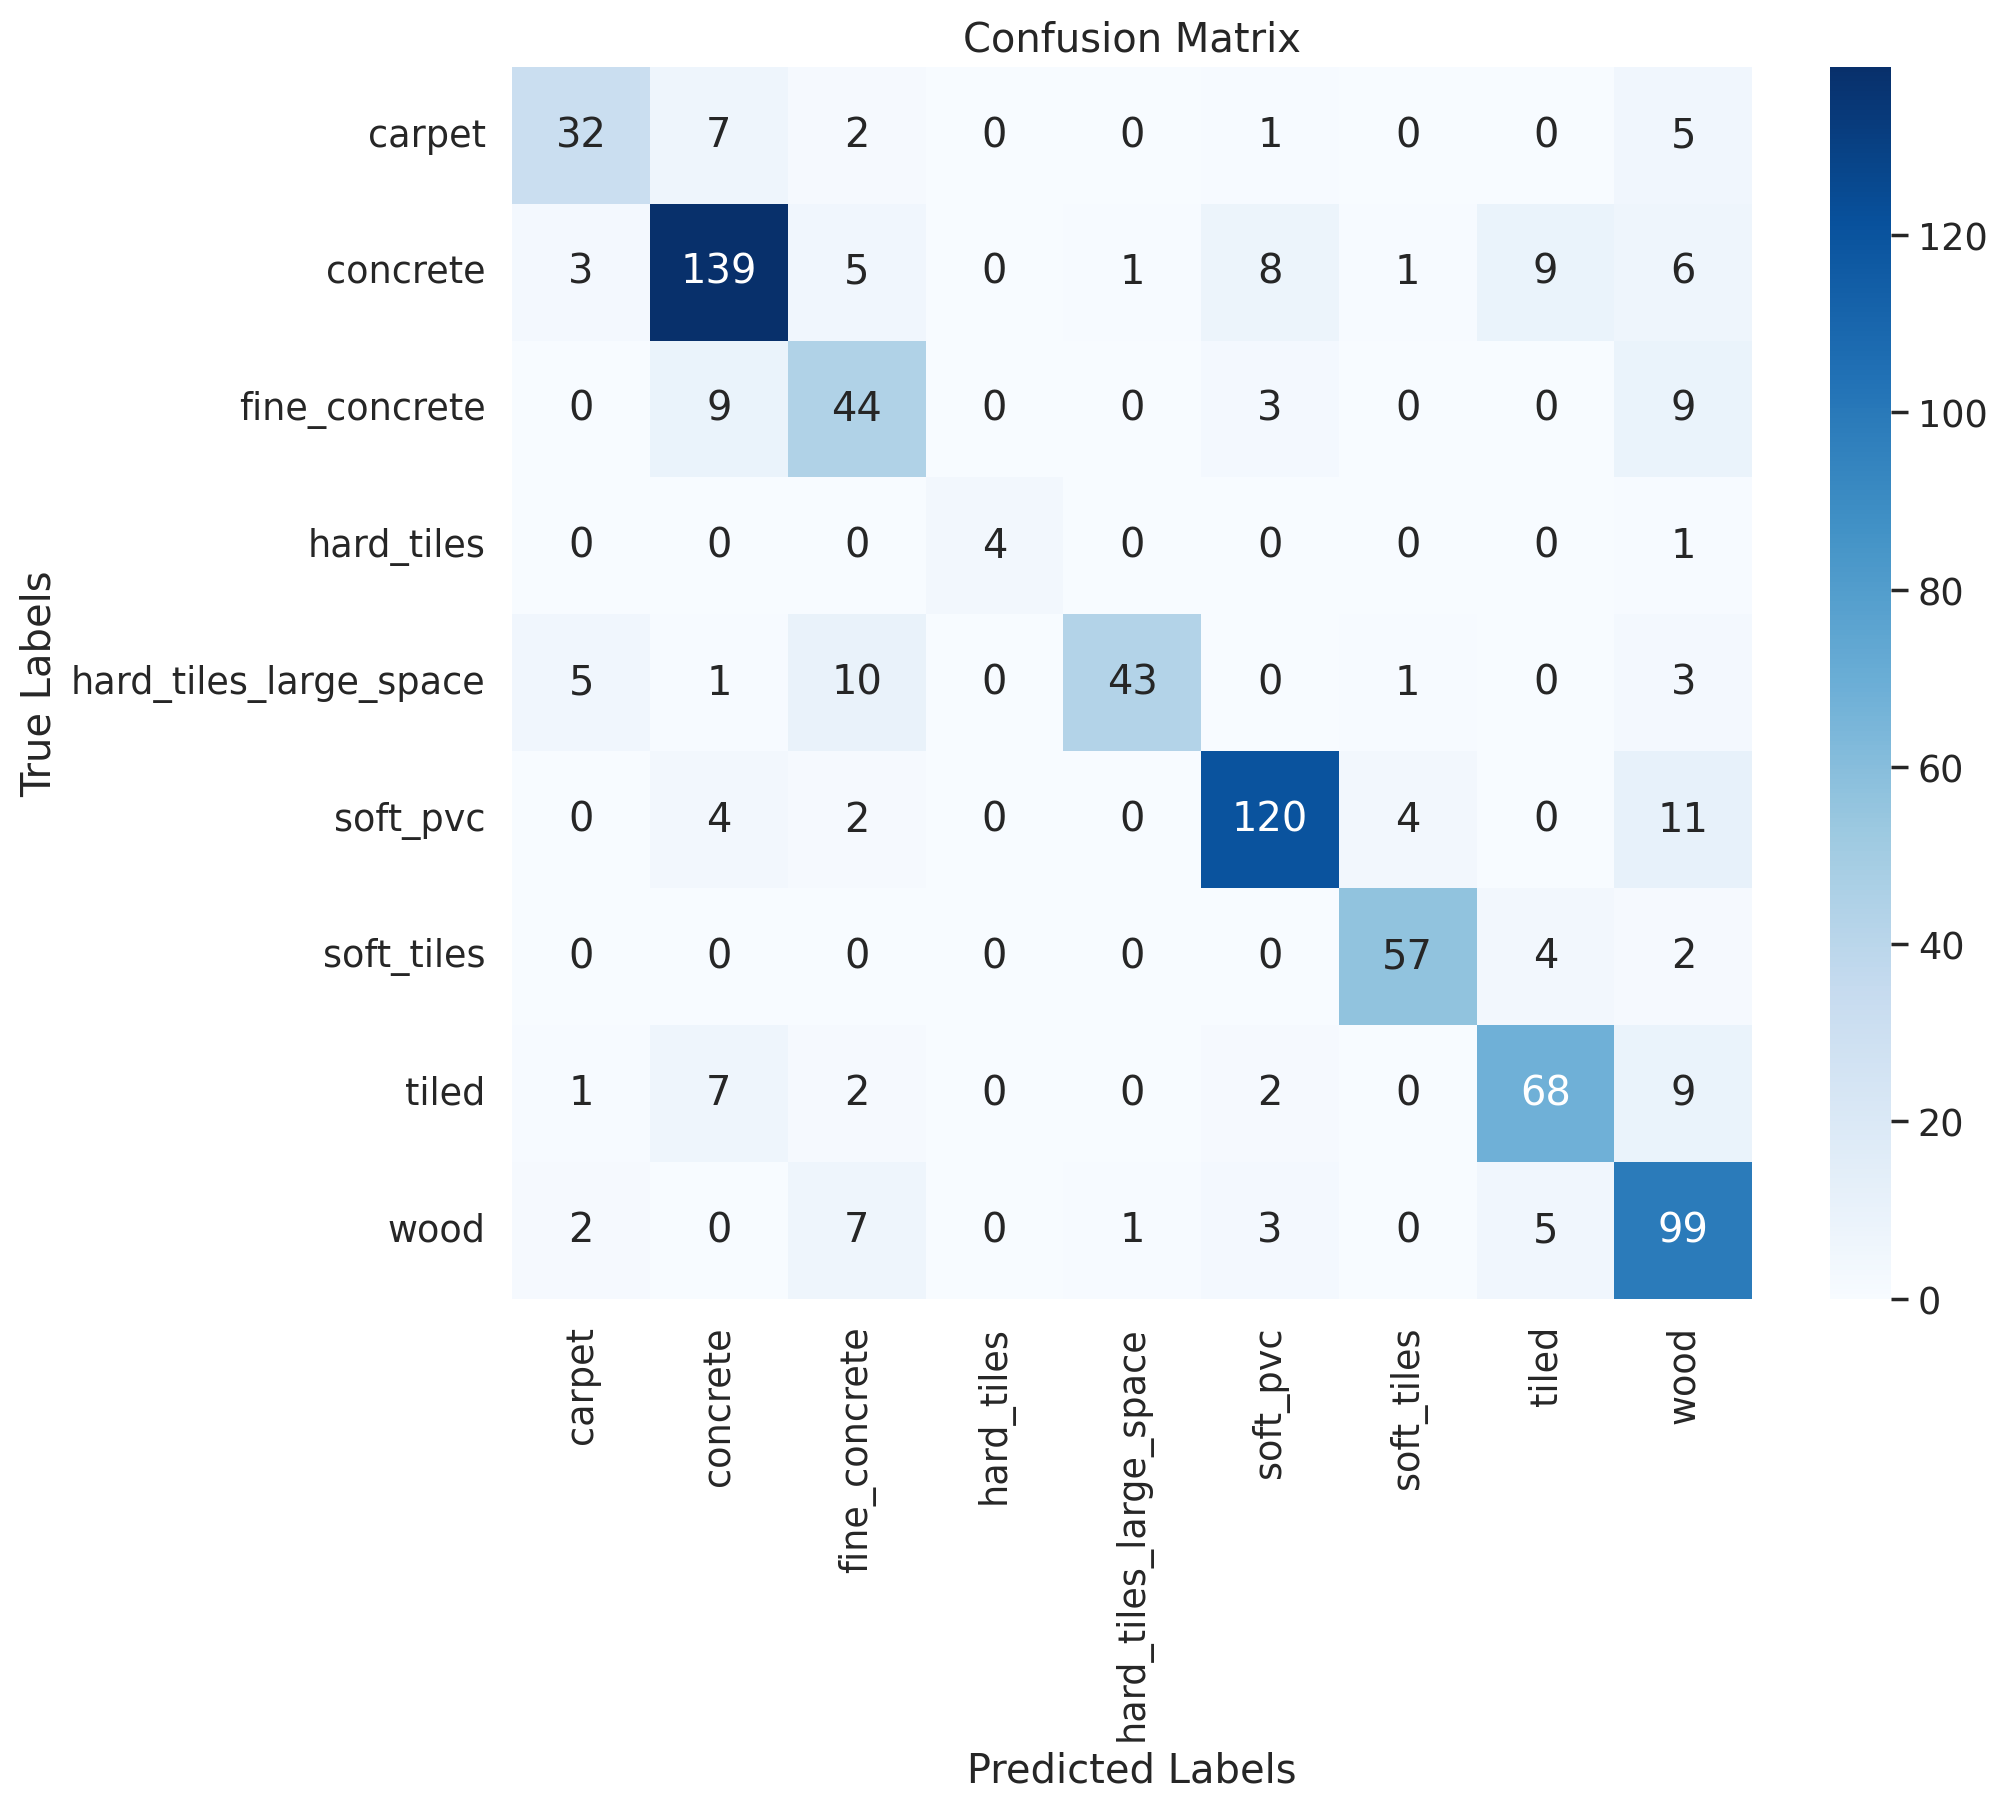

In [279]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()